<a href="https://colab.research.google.com/github/EleonoraBartolomucci/Fairness/blob/master/exposure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from lxml import html
import pandas as pd
import json
import csv
import numpy as np
import itertools
import os
import pickle
import random
import datetime
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import statistics as st
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

#!pip install balanced_kmeans
#from balanced_kmeans import kmeans
#from balanced_kmeans import kmeans_equal

import networkx as nx
import time


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

root_path = 'gdrive/My Drive/Tesi/Fairness/data/fairness_data/'


In [0]:
# CONSTANTS
business_headers = ['index', 'business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']
FOLDER = {'WbJ1LRQdOuYYlRLyTkuuxw':
            {'FID_RANKING': '1U0Ml5puObfOk3qHCKhO9bQ06WyhJoffW',
             'FID_G1': '1cauvqKXzF5VhiveP84aL3U0oDrXP32XV',
             'FID_G2': '1vC1fc2owpCis_PTl1ABKT6BfG6-2yoiJ',
             'FID_G3': '1_iKbmJkBwWEEIIh73UvR431Ss6xnGb2f',
             'FID_G4': '1m_feamMvpx5B5mTe_lH6qlhoZFEpwlSs',
             'FID_G5': '1qJgFbR4FUX5t7O9h5cHgp6aE6lpfbdOs',
             'FID_G6': '1BSQrghVusO_eNbe10fFE4-bVfRK8ly0y',
             'FID_G7': '1fJD4WIErH-u5plesyTePCAQ3IyfjoOKf',
             'FID_G8': '1fD_fdl-1KAzXCjPOsEvFOZS3u354XhLL',
             'FID_G9': '1ZdiaS2cZP9Ks3rheSSVaoLpw-qMYF9EA',
             'FID_G10': '',
             'FID_G11': '1ce7VQPdbQ9ieimmpz66RaHgbzEFa4TsT',
             'FID_G12': '1tf-KwOYXdMGS3uYdoe8Kc4LV-rdxHY_3',
             'FID_G13': '1zrIsEjhaSqDfGqhBBZu5cYg7_9RsXLcQ',
             'FID_G14': '1ry0OF9h4oJVYwF6Uw4AF18SIYKJUc0vd'
             },
          'T2tEMLpTeSMxLKpxwFdS3g':
            {'FID_RANKING': '136FZ0Y90Zx-4UYDyW50cX8zUa_DhN3XS',
             'FID_G1': '1eiju1aTzsRi4QQZ8XrSouqcLtFSN-tbj',
             'FID_G2': '1VuU8MAcXgN_E85q9SH_P1HsHVkeJakwH',
             'FID_G3': '1L240ycUElvmF0R4l8PbnuoBbqQY6q1og',
             'FID_G4': '1S4oTf-ZSD8q9aTOjrDEA2KeNJ99uh-2n',
             'FID_G5': '1u9ZFeCwmol1uXRH-l8djJ2hst0B01VI3',
             'FID_G6': '19TgwV3uHOtDDJ0a8krpvLUeooe9rhQFJ',
             'FID_G7': '11YpFHw34cDglPD87W8yWvRM1VAOWXPtF',
             'FID_G8': '1tR-GotUUNgiilJLBxvr7PkUpbPG5F_J7',
             'FID_G14': '1pTbQYeLXVTzZTIDdHOtmaWZER5h_QYBK',
             },
          'ALwAlxItASeEs2vYAeLXHA':
            {'FID_RANKING': '12zXi3XyQaNgukGHW_805cyrkHhSdF7Df',
             'FID_G1': '1NB-isOm1cDArAlwIMDMou1Q_XAap09KA',
             'FID_G2': '1ELMUBbKGryblHDnbh7ghiIgMdZ48pBG1',
             'FID_G3': '1QZ90pwDjBoaU41P8wP8v_I9tsuhObEUP',
             'FID_G4': '1MXivbV9VGB0vBGGuLhYu0zJlpv6O-2Xb',
             'FID_G5': '1bTetFx3Jhy5QbRKYGV09muMy7D1NKmJT',
             'FID_G6': '1F_7bdMS5MW4sIpyUbDz62ZTYJtHoouGG',
             'FID_G7': '1uRFceNIlYk5vQXEGd2H6yanrlwrSIM9V',
             'FID_G14': '1Ef87ewaZbBr6OmMdXAK8kZ3-0tIfXVj8',
             },
          'OVTZNSkSfbl3gVB9XQIJfw':
            {'FID_RANKING': '1ZyNQavpG0akr3ca3PJjjl_D89IA5wlcc',
             'FID_G1': '1kQkAi_9V3mSld1LlP50j6uw0bwqnkLrR',
             'FID_G2': '1hGR4eZiP3Q9Etn7RdlY58IsNsTMMTydz',
             'FID_G3': '1YcAPHxioFpiVXWndO5tK17US1h36cWgK',
             'FID_G4': '1NxzzH0l18fGaO4bZ35D9NMq2CeW5BRVP',
             'FID_G5': '1HC1wZGPtbb8UvRlfbGoHl_ijl3G67Ei4',
             'FID_G6': '1J_15pO-CFbHR_0YsHK5kDnKp49kDL0kZ',
             'FID_G7': '1RTwCqhYzB3djzpe3-uwbQ3Ur5P8YoECa',
             'FID_G14': '1ivduQ-XS-1sUBmJIb1j-ZDGGG5xxM5H5',
             },
          'Sovgwq-E-n6wLqNh3X_rXg':
            {'FID_RANKING': '1EZqvt9x5PN07BgUad1RtNIUXTVqujA0g',
             'FID_G1': '1pkUEBYeZ66GfIvXoTkzZ28gGFlZNWmEq',
             'FID_G2': '1lJzHAfBlvL9_EgNizH4vnyPTn-j-Vbrx',
             'FID_G3': '1NRYqjUsQJTwgB0JXtcCx7lQErirMH1TK',
             'FID_G4': '1nLtZbS0NGXKAs6aETNs7EWasNs8omaw6',
             'FID_G5': '14w-jVhOuod3s_EYSipvS92SPx_3zT_FD',
             'FID_G6': '1tbUyiamFmyAoeA3W6j51x97h3MjUSVsd',
             'FID_G7': '1TNAmibHwJHkvNajHhRffN1gEY0-QnBZH',
             'FID_G14': '1MXc5Z-KchS-NhvILmmRIAk64ElB7a17f',
             },
          'j5nPiTwWEFr-VsePew7Sjg':
            {'FID_RANKING': '18bQVXYZ03vIpfEFLPh8I2i7cPTlokGxv',
             'FID_G1': '1U8STZ7irZLPcUpP1ALR6QYIFnoXB2tbE',
             'FID_G2': '1xScKc0_DlnQZucHLeb26hLqpgjqMA3RH',
             'FID_G3': '1JFYl2eKtDyWbsyVdBpTXsvPn2h6MO3Cr',
             'FID_G4': '1aFYpJmymdnHxquuqbbMwXzN5wG-3Zf2O',
             'FID_G5': '1NfHlsBTk87jscmZfagtnd--kcdpy8t_8',
             'FID_G6': '1b88afNqrZSRptYA0pL3lCEV49mFaEP6Q',
             'FID_G7': '15rDbY-MTUBVjHxOedbenZIjTxQ_wEAZW',
             'FID_G14': '1B9SAbA0-BB5EIFAT1x8ZgBJI543L9woa',
             },
          'aiX_WP7NKPTdF9CfI-M-wg':
            {'FID_RANKING': '1nl6A997UnuR5ceYRZS1242JJCvK-Sf_u',
             'FID_G1': '1hrssLlhPmnS48yVxXpwBBIuhL1YdDNhj',
             'FID_G2': '1shLPc3aUsVaxeZhZ_SvDS3agPFlMw1dn',
             'FID_G3': '13eUtYFVp-KKjxV6-mhCsxQGHkKFOgB82',
             'FID_G4': '1nQVPHZT4sHpBXD32qX_x41VywkmyppFj',
             'FID_G5': '1gJpfGhb721Q64gynq4jSGMis5pDA7qAx',
             'FID_G6': '1WbZvolaSwambWOKHx4v4eFIV-KUzygGF',
             'FID_G7': '1IWyQpgMjLny2JTbw0nUuHkNRPV5CCA_A',
             'FID_G14': '1sxBZUfSHX9H9YCiLH2rmZu4_3JkiFkZS',
             },
          'e4NQLZynhSmvwl38hC4m-A':
            {'FID_RANKING': '1K566Y5Q2N6Lw7S6yDicKC_R-zFVRqnFr',
             'FID_G1': '1RNxub2faGfc4NAFvau5SsMADAzBlQd2j',
             'FID_G2': '16tjv4k5CJSOxwgvC0wDJU67MEjRaw_0o',
             'FID_G3': '1p-9HrVncD_FZOxO0YzHiY7KTe47ugSTQ',
             'FID_G4': '1qGpECepAyJjqyfPx8Q94odPOCHbOixtZ',
             'FID_G5': '15AGLE1YT0v8tQ3r6i6k7j5XaNORToUct',
             'FID_G6': '1nNbAPulqJCzO6urHNsqc4qzSM7Yih8uk',
             'FID_G7': '1o9Ew39-Q9VO3wjEyv4qGJ9YlfRmkzTed',
             'FID_G14': '11QOBb79y1g-sy9xQxwihoiTZrOOIKm6l',
             },
          'S-oLPRdhlyL5HAknBKTUcQ':
            {'FID_RANKING': '1FJqfJgaJinXS3oIvdA53FMuO9O7bCDVn',
             'FID_G1': '1CcLHVEA41AgSzJKl37YlcJKf-o5NaCUo',
             'FID_G2': '1j-lp1gcu6YGTwcOV4aYiY7dh2G9_TL6J',
             'FID_G3': '1I-Qn9oz4VopXbpj5i8_iqLvcSp8jpb2_',
             'FID_G4': '1gsS9uFbRyI18ifF5yLp20WHhP66gdr57',
             'FID_G5': '1LJIVm9tCZMcgzBkGilYem0nqKoUHpdpX',
             'FID_G6': '1syB0wF48fiSo0_uW9dedS-ZlFfXUv1B8',
             'FID_G7': '1cBPjBprJ19RxI6-Bcpb-Fifv0s1bQSV2',
             'FID_G14': '1x83XV4b38hQvTo2H6-NAZ0kriB5uBhxq',
             }
        }


In [0]:
def upload_file(filename, folder_id):
  drive = authenticate()
  fileList = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  drive_file = drive.CreateFile({'title': filename, 'parents': [{'id': folder_id}]})
  # Check if file already exists in Google Drive (prevents duplicates)
  for file in fileList:
      if file['title'] == filename:  # The file already exists, then overwrite it
          fileID = file['id']
          drive_file = drive.CreateFile({'id': fileID, 'title': filename, 'parents': [{'id': folder_id}]})

  # Create a local copy of user picture
  # Already created!

  # Upload user picture on Google Drive
  drive_file.SetContentFile(filename)  # path of local file content
  drive_file.Upload()  # Upload the file.
  
  # Delete local user pictures
  #if os.path.exists(filename):
  #    os.remove(filename)
  #else:
  #    print("The file does not exist")

def set_file_destination(lst, method, id):
  if method == 'ranking':
    return FOLDER[id]['FID_RANKING']
  if lst == ['review_count']:
    return FOLDER[id]['FID_G1']
  if lst == ['fans']:
      return FOLDER[id]['FID_G6']
  if method == 'kmeans':
    if lst == ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool']:
      return FOLDER[id]['FID_G2']
    if lst == ['loc1', 'loc2', 'loc3']:
      return FOLDER[id]['FID_G3']
    if lst == ['age', 'gender', 'ethnicity']: 
      return FOLDER[id]['FID_G4']
    if lst == ['useful','funny', 'cool']:
      return FOLDER[id]['FID_G7']
    if lst == ['review_count', 'friend_count', 'photo_count']:
      return FOLDER[id]['FID_G13']
  if method == 'balanced_kmeans':
    if lst == ['age', 'gender', 'ethnicity']:
      return FOLDER[id]['FID_G8']
    if lst == ['loc1', 'loc2', 'loc3']:
      return FOLDER[id]['FID_G9']
  if method == 'custom':
    if lst == ['gender', 'ethnicity']:
      return FOLDER[id]['FID_G12']
    if lst == ['review_sentiment']:
      return FOLDER[id]['FID_G5']
    if lst == ['ethnicity']:
      return FOLDER[id]['FID_G11']
    if lst == ['gender']:
      return FOLDER[id]['FID_G14']
  if method == 'dbscan':
    if lst == ['review_count', 'friend_count', 'photo_count']:
      return FOLDER[id]['FID_G13']



# READ JSON
def read_json(json_path):
  data = []
  with open(json_path, "r") as my_file: 
    for line in my_file:
      line_json = json.loads(line)
      data.append(line_json)
  return data


# PARSE JSON IN CSV
def json2csv(csv_path, json_path):
  data = read_json(json_path)
  df = pd.DataFrame(data)
  df.to_csv(csv_path)


def drop_unnamed(df):
  cols = [c for c in df.columns if c.lower()[:7] != 'unnamed']
  return df[cols]

In [0]:
# AUTHENTICATE IN GOOGLE DRIVE
def authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive
drive = authenticate()

In [18]:
# DOWNLOAD user.json FROM DRIVE
users_dataset_id = '1JokoV68YD5Iq2l4Y_IV2RJzBpD_mSCyq'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': users_dataset_id})
download.GetContentFile('user.json')
users = read_json('user.json')
users = pd.DataFrame(users)

# DOWNLOAD business.json FROM DRIVE
business_dataset_id = '1Qoy132gb205xAIFjkBbZ2CyYDeaz9yqU'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': business_dataset_id})
download.GetContentFile('business.json')
business = read_json('business.json')
business = pd.DataFrame(business)

# DOWNLOAD review.json FROM DRIVE
review_dataset_id = '1mW1WbpMFjN0qQpLnM-R_TzNpAkFsBLHQ'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': review_dataset_id})
download.GetContentFile('review.json')
reviews = read_json('review.json')
reviews = pd.DataFrame(reviews)

# DOWNLOAD DEMOGRAPHICS
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A', 'S-oLPRdhlyL5HAknBKTUcQ']
#id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
file_id_list = {'WbJ1LRQdOuYYlRLyTkuuxw':['1uuA0QH-DJklvtiekxS-7yaXfKRi9ux06'],
#                                          '13amOFvuku27snF8mea8Yp7rH36Mve42N',
#                                          '1VskD_0Ijwe3_fzVbgYqK9Bk-YOCK046t',
#                                          '1uuA0QH-DJklvtiekxS-7yaXfKRi9ux06'],
                'T2tEMLpTeSMxLKpxwFdS3g':['102OYWJOKF54GMnFh4_AKc5e_Mz7xiXZt'],
                                          #'11fM_aHYkCLQ2z3g7Z76aZZ3cAsIrpezN',
                                          #'102OYWJOKF54GMnFh4_AKc5e_Mz7xiXZt',
                                          #'1ObvjBbxRNIp1vOQipUGZxZEi_eQH7kJQ'],
                'ALwAlxItASeEs2vYAeLXHA':['1sJOKR7-__9dKJG0ewVQyfmV6i_dLpcRk'],
                                          #'1crTNpDR2VjBdGSgavIvN4QNhwTUR3-Bk',
                                          #'1sJOKR7-__9dKJG0ewVQyfmV6i_dLpcRk',
                                          #'1tgJnMW0ZImx1vbDzWpvFBRX0FJu1Kdbt'],
                'OVTZNSkSfbl3gVB9XQIJfw':['12aiPnkvuUtyc8B2UmJEu2BpeXVYbPumF'],
                                          #'1Vmkzpdi_0m9CGcyp5ggeNsUsueBzqufH',
                                          #'12aiPnkvuUtyc8B2UmJEu2BpeXVYbPumF',
                                          #'1qecYhCBytq1Z6lm_ueCWIuithvRG0wIq'],
                'Sovgwq-E-n6wLqNh3X_rXg':['1fSqJYcczjUsbryfI7ekeqANaz-xD4PFT'],
                                          #'1VVePrvWR7e5XkRmhp5Q5qOPXPskVmnnt',
                                          #'1fSqJYcczjUsbryfI7ekeqANaz-xD4PFT',
                                          #'1R5GFYo2c2YC_AOB9G0pdOfROTyglePDI'],
                'j5nPiTwWEFr-VsePew7Sjg':['16H267f71Y_1l8O5-n5JlF5v8GNpnt_kc'],
                                          #'1txkAzGKMRjXku18rv9222q-FqVo42A9o',
                                          #'1e8iSM3SpyB2Y_h6rzRSVVgphjHEIJnZU',
                                          #'16H267f71Y_1l8O5-n5JlF5v8GNpnt_kc'],
                'aiX_WP7NKPTdF9CfI-M-wg':['1ApgXp06OyhQSgFg4pyxaH_vF6djUFmNc'],
                                          #'1VrVgBoJp5cRVMH4I-5uKvdF3b-PSfbmL',
                                          #'1f7T7ksdCCGxhVF_RJU9zu38-r8aTTJcD',
                                          #'1ApgXp06OyhQSgFg4pyxaH_vF6djUFmNc'],
                'e4NQLZynhSmvwl38hC4m-A':['1-myKdlTuCpUyPuK8OwHhglpQQGe7Bh-y'],
                                          #'1yYG8ftjE1i9prP61ej5EdGfJDlweiK3C',
                                          #'1KSdN24eXC-Bnk2_mTQR6oNaGll1KP5hO',
                                          #'1-myKdlTuCpUyPuK8OwHhglpQQGe7Bh-y'],
                'S-oLPRdhlyL5HAknBKTUcQ':['1XrZViuuarqibJmaURcb0SHU5nd_3zGpo']}
                                          #'1qcX9pGfmogOokbBOPnZY-NbroolffAlg',
                                          #'1YVdSND3VNit4ieORXC_mVzcv4mphGUnY',
                                          #'1XrZViuuarqibJmaURcb0SHU5nd_3zGpo']}
for business_id in id_list:
  df = pd.DataFrame()

  for file_id in file_id_list[business_id]:
    download = drive.CreateFile({'id': file_id})
    download.GetContentFile('demographics_' + business_id + '.csv')
    df_temp = pd.read_csv('demographics_' + business_id + '.csv')
    df = df.append(df_temp)
    
  print(len(df.index))
  df = df.sort_values(['id', 'age'], ascending=[True, False])
  df = df.drop_duplicates('id',keep='first').reset_index(drop=True)
  print('senza duplicati: ', len(df.index))
  df = df.rename(columns={'id':'user_id'})
  df = drop_unnamed(df)
  df.to_csv('demographics_' + business_id + '.csv')
  upload_file('demographics_' + business_id + '.csv',FOLDER[business_id]['FID_G4'])

# DOWNLOAD SENTIMENT ANALYSIS
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A']
#id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
file_id_list = {'WbJ1LRQdOuYYlRLyTkuuxw':[#'1z4r5wJJVHy65OGWo4VFBz0vviAebPr9D',
                                          '1DsOTrTZepa8DAeSGf8v7suIwdc7bm8jB'],
                                          #'19sQ-pbO2dGsax5dpGeLQBnSgX34GSu3t'],
                'T2tEMLpTeSMxLKpxwFdS3g':['1SwQWQnchjrKmJHq6ZQIHCgsKKNvzs2B4'],
                                          #'11fM_aHYkCLQ2z3g7Z76aZZ3cAsIrpezN',
                                          #'1TPexYC2YHq_8ywZSuRRIJkrUCstwoxSp',
                                          #'1ObvjBbxRNIp1vOQipUGZxZEi_eQH7kJQ'],
                'ALwAlxItASeEs2vYAeLXHA':[#'1crTNpDR2VjBdGSgavIvN4QNhwTUR3-Bk',
                                          '1kqjtQ5WQfPAUcOZNdpGZmn4tyTeqi3Ua'],
                                          #'1sJOKR7-__9dKJG0ewVQyfmV6i_dLpcRk',
                                          #'1tgJnMW0ZImx1vbDzWpvFBRX0FJu1Kdbt'],
                'OVTZNSkSfbl3gVB9XQIJfw':[#'1Vmkzpdi_0m9CGcyp5ggeNsUsueBzqufH',
                                          '1wxP30ZDwl1hR_Ev3SNXB6Fpq9DMtBbD_'],
                                          #'12aiPnkvuUtyc8B2UmJEu2BpeXVYbPumF',
                                          #'1qecYhCBytq1Z6lm_ueCWIuithvRG0wIq'],
                'Sovgwq-E-n6wLqNh3X_rXg':[#'1VVePrvWR7e5XkRmhp5Q5qOPXPskVmnnt',
                                          '1np0WOU9aH6Iwoa-cgrlc6_EwfQRQ8pWG'],
                                          #'1fSqJYcczjUsbryfI7ekeqANaz-xD4PFT',
                                          #'1R5GFYo2c2YC_AOB9G0pdOfROTyglePDI'],
                'j5nPiTwWEFr-VsePew7Sjg':[#'1txkAzGKMRjXku18rv9222q-FqVo42A9o',
                                          '1y76OtwUcjZ9e4Pokn55qk6ZS7e7qCtDQ'],
                                          #'1e8iSM3SpyB2Y_h6rzRSVVgphjHEIJnZU',
                                          #'16H267f71Y_1l8O5-n5JlF5v8GNpnt_kc'],
                'aiX_WP7NKPTdF9CfI-M-wg':[#'1VrVgBoJp5cRVMH4I-5uKvdF3b-PSfbmL',
                                          '1lV9wxvN4zYf2-VxpwoYVBncCpZQPxmTv'],
                                          #'1f7T7ksdCCGxhVF_RJU9zu38-r8aTTJcD',
                                          #'1ApgXp06OyhQSgFg4pyxaH_vF6djUFmNc'],
                'e4NQLZynhSmvwl38hC4m-A':[#'1yYG8ftjE1i9prP61ej5EdGfJDlweiK3C',
                                          '1Ls9NjEU5FuCOyxsbbFVNEwCJioDO_e29'],
                                          #'1KSdN24eXC-Bnk2_mTQR6oNaGll1KP5hO',
                                          #'1PA2eYsYj2bj4Mo7ofbnvbQgYjmd2SwRG'],
                'S-oLPRdhlyL5HAknBKTUcQ':[#'1qcX9pGfmogOokbBOPnZY-NbroolffAlg',
                                          '1vVFHYIBf4Y_3G7neGfz7XFobNd13SUph']}
                                          #'1YVdSND3VNit4ieORXC_mVzcv4mphGUnY',
                                          #'1XrZViuuarqibJmaURcb0SHU5nd_3zGpo']}
for business_id in id_list:
  df = pd.DataFrame()

  for file_id in file_id_list[business_id]:
    download = drive.CreateFile({'id': file_id})
    download.GetContentFile('sentiment_' + business_id + '.csv')
    df_temp = pd.read_csv('sentiment_' + business_id + '.csv')
    df = df.append(df_temp)
    
  print(len(df.index))
  df = df.drop_duplicates('id',keep='first').reset_index(drop=True)
  print(len(df.index))
  df = df.rename(columns={'id':'user_id'})
  df = drop_unnamed(df)
  df.to_csv('sentiment_' + business_id + '.csv')
  upload_file('sentiment_' + business_id + '.csv',FOLDER[business_id]['FID_G5'])

KeyboardInterrupt: ignored

In [21]:
# DOWNLOAD SENTIMENT ANALYSIS
id_list = ['S-oLPRdhlyL5HAknBKTUcQ']
#id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
file_id_list = {'WbJ1LRQdOuYYlRLyTkuuxw':[#'1z4r5wJJVHy65OGWo4VFBz0vviAebPr9D',
                                          '1DsOTrTZepa8DAeSGf8v7suIwdc7bm8jB'],
                                          #'19sQ-pbO2dGsax5dpGeLQBnSgX34GSu3t'],
                'T2tEMLpTeSMxLKpxwFdS3g':['1SwQWQnchjrKmJHq6ZQIHCgsKKNvzs2B4'],
                                          #'11fM_aHYkCLQ2z3g7Z76aZZ3cAsIrpezN',
                                          #'1TPexYC2YHq_8ywZSuRRIJkrUCstwoxSp',
                                          #'1ObvjBbxRNIp1vOQipUGZxZEi_eQH7kJQ'],
                'ALwAlxItASeEs2vYAeLXHA':[#'1crTNpDR2VjBdGSgavIvN4QNhwTUR3-Bk',
                                          '1kqjtQ5WQfPAUcOZNdpGZmn4tyTeqi3Ua'],
                                          #'1sJOKR7-__9dKJG0ewVQyfmV6i_dLpcRk',
                                          #'1tgJnMW0ZImx1vbDzWpvFBRX0FJu1Kdbt'],
                'OVTZNSkSfbl3gVB9XQIJfw':[#'1Vmkzpdi_0m9CGcyp5ggeNsUsueBzqufH',
                                          '1wxP30ZDwl1hR_Ev3SNXB6Fpq9DMtBbD_'],
                                          #'12aiPnkvuUtyc8B2UmJEu2BpeXVYbPumF',
                                          #'1qecYhCBytq1Z6lm_ueCWIuithvRG0wIq'],
                'Sovgwq-E-n6wLqNh3X_rXg':[#'1VVePrvWR7e5XkRmhp5Q5qOPXPskVmnnt',
                                          '1np0WOU9aH6Iwoa-cgrlc6_EwfQRQ8pWG'],
                                          #'1fSqJYcczjUsbryfI7ekeqANaz-xD4PFT',
                                          #'1R5GFYo2c2YC_AOB9G0pdOfROTyglePDI'],
                'j5nPiTwWEFr-VsePew7Sjg':[#'1txkAzGKMRjXku18rv9222q-FqVo42A9o',
                                          '1y76OtwUcjZ9e4Pokn55qk6ZS7e7qCtDQ'],
                                          #'1e8iSM3SpyB2Y_h6rzRSVVgphjHEIJnZU',
                                          #'16H267f71Y_1l8O5-n5JlF5v8GNpnt_kc'],
                'aiX_WP7NKPTdF9CfI-M-wg':[#'1VrVgBoJp5cRVMH4I-5uKvdF3b-PSfbmL',
                                          '1lV9wxvN4zYf2-VxpwoYVBncCpZQPxmTv'],
                                          #'1f7T7ksdCCGxhVF_RJU9zu38-r8aTTJcD',
                                          #'1ApgXp06OyhQSgFg4pyxaH_vF6djUFmNc'],
                'e4NQLZynhSmvwl38hC4m-A':[#'1yYG8ftjE1i9prP61ej5EdGfJDlweiK3C',
                                          '1Ls9NjEU5FuCOyxsbbFVNEwCJioDO_e29'],
                                          #'1KSdN24eXC-Bnk2_mTQR6oNaGll1KP5hO',
                                          #'1PA2eYsYj2bj4Mo7ofbnvbQgYjmd2SwRG'],
                'S-oLPRdhlyL5HAknBKTUcQ':[#'1qcX9pGfmogOokbBOPnZY-NbroolffAlg',
                                          '1vVFHYIBf4Y_3G7neGfz7XFobNd13SUph']}
                                          #'1YVdSND3VNit4ieORXC_mVzcv4mphGUnY',
                                          #'1XrZViuuarqibJmaURcb0SHU5nd_3zGpo']}
for business_id in id_list:
  df = pd.DataFrame()

  for file_id in file_id_list[business_id]:
    download = drive.CreateFile({'id': file_id})
    download.GetContentFile('sentiment_' + business_id + '.csv')
    df_temp = pd.read_csv('sentiment_' + business_id + '.csv')
    df = df.append(df_temp)
    
  print(len(df.index))
  df = df.drop_duplicates('id',keep='first').reset_index(drop=True)
  print(len(df.index))
  df = df.rename(columns={'id':'user_id'})
  df = drop_unnamed(df)
  df.to_csv('sentiment_' + business_id + '.csv')
  upload_file('sentiment_' + business_id + '.csv',FOLDER[business_id]['FID_G5'])

1419
1419


In [0]:
# EXEC IN LOCAL THE DOWNLOAD OF REVIEW RANKINGS OF EACH RESTAURANT
# UPLOAD CSV IN COLAB
############################# EXECUTE IN LOCAL (if not blocked by yelp) #############################################
def get_ranking_from_call(url_business, lang, sort, query):
    headers = [{"name": "Accept", "value": "*/*"}, {"name": "Accept-Encoding", "value": "gzip, deflate, br"},
               {"name": "Accept-Language", "value": "it-IT,it;q=0.8,en-US;q=0.5,en;q=0.3"},
               {"name": "Connection", "value": "keep-alive"},
               {"name": "Content-Type", "value": "application/x-www-form-urlencoded; charset=utf-8"}, {"name": "Cookie",
                                                                                                       "value": "qntcst=D; hl=en_US; wdi=1|3C26116D69138F61|0x1.78d019f71a444p+30|a7756ff94751d3a9; _ga=GA1.2.3C26116D69138F61; location=%7B%22city%22%3A+%22New+York%22%2C+%22state%22%3A+%22NY%22%2C+%22country%22%3A+%22US%22%2C+%22latitude%22%3A+40.713%2C+%22longitude%22%3A+-74.0072%2C+%22max_latitude%22%3A+40.8523%2C+%22min_latitude%22%3A+40.5597%2C+%22max_longitude%22%3A+-73.7938%2C+%22min_longitude%22%3A+-74.1948%2C+%22zip%22%3A+%22%22%2C+%22address1%22%3A+%22%22%2C+%22address2%22%3A+%22%22%2C+%22address3%22%3A+null%2C+%22neighborhood%22%3A+null%2C+%22borough%22%3A+null%2C+%22provenance%22%3A+%22YELP_GEOCODING_ENGINE%22%2C+%22display%22%3A+%22New+York%2C+NY%22%2C+%22unformatted%22%3A+%22New+York%2C+NY%2C+US%22%2C+%22accuracy%22%3A+4.0%2C+%22language%22%3A+null%7D; xcj=1|Ptt9P03gfc75x_PBT9zmqCkUuSuyB7PR-wWUBvABNi4; __qca=P0-60561249-1581956668708; G_ENABLED_IDPS=google; __cfduid=db8764ff59d8028a6c2e1b214867927d81583160194; _gid=GA1.2.2014867238.1583835527; bse=05dcd9d5de304ef0b1d9a76fa768b10f; sc=8a1ca0dbc2; pid=505721aa4569e7bb"},
               {"name": "Host", "value": "www.yelp.com"},
               {"name": "Referer", "value": "https://www.yelp.com/biz/noche-de-margaritas-new-york"},
               {"name": "TE", "value": "Trailers"}, {"name": "User-Agent",
                                                     "value": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:73.0) Gecko/20100101 Firefox/73.0"},
               {"name": "X-Requested-By-React", "value": "true"},
               {"name": "X-Requested-With", "value": "XMLHttpRequest"}]
    headers_ok = {}
    for header in headers:
        temp = {
            header['name']: header['value']
        }
        headers_ok.update(temp)

    x = 0
    reviews_list = []
    position = 1
    url = url_business + "/review_feed?rl=" + lang + "&sort_by=" + sort + "&q=" + query

    while 1:
        if x == 0:
            page_load = requests.get(url + '&start=', headers=headers_ok)
        else:
            page_load = requests.get(url + '&start=' + str(x), headers=headers_ok)
        print(page_load)
        x = x + 20
        reviews = page_load.json()['reviews']
        # print(json.dumps(reviews, indent=4, sort_keys=True))
        if not reviews:
            break
        for review in reviews:
            reviews_list.append((position, review['userId'], review['user'],
                                 review['comment'], review['feedback'],
                                 datetime.datetime.strptime(review['localizedDate'], '%m/%d/%Y')))
            position = position + 1
    df_reviews = pd.DataFrame(reviews_list, columns=["position", "user_id", "user",
                                                     "comment", "feedback", "date"])
    return df_reviews


def retrieve_rankings(business_id):
    df_rel_ranking = get_ranking_from_call("https://www.yelp.com/biz/" + business_id, "en", "relevance_desc", "")
    df_date_ranking = df_rel_ranking.sort_values(by=['date']).reset_index(drop=True)
    df_date_ranking['position'] = df_date_ranking.index + 1
    df_rand_ranking = df_rel_ranking.sample(frac=1).reset_index(drop=True)
    df_rand_ranking['position'] = df_rand_ranking.index + 1

    df_rel_ranking = drop_unnamed(df_rel_ranking)
    df_rand_ranking = drop_unnamed(df_rand_ranking)
    df_date_ranking = drop_unnamed(df_date_ranking)

    df_rel_ranking.to_csv("rel_ranking_" + business_id + ".csv")
    df_date_ranking.to_csv("date_ranking_" + business_id + ".csv")
    df_rand_ranking.to_csv("rand_ranking_" + business_id + ".csv")

    destination = set_file_destination('', 'ranking', business_id)
    upload_file("rel_ranking_" + business_id + ".csv", destination)
    upload_file("date_ranking_" + business_id + ".csv", destination)
    upload_file("rand_ranking_" + business_id + ".csv", destination)


business_ids = ['Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A', 'S-oLPRdhlyL5HAknBKTUcQ']

for id in business_ids:
    retrieve_rankings(id)

In [0]:
# JOIN USER FROM YELP WITH USER FROM DATASET AND PRINT LOST USERS
def filter_user_from_dataset(df, users):
  df = df[['position','user_id','date','location']] # Tolgo alcune colonne perché prendo quelle del dataset
  df_merged = df.merge(users, on='user_id')
  total_review = df['position'].max()
  print('Utenti persi: totali ' + str(total_review) + ' - utenti nel dataset ' +
        str(len(df_merged.index)) + ' = ' + str(total_review - len(df_merged.index)))
  df_merged['position'] = df_merged.index + 1
  df_merged = drop_unnamed(df_merged)
  return df_merged


def compute_groups_percents(df_groups, N_of_groups):
  total = len(df_groups.index)
  percents = []
  i = 0
  while i < N_of_groups:
    current_length = len(df_groups[df_groups['group_id'] == i].index)
    percents.append((current_length/total)*100)
    i = i + 1
  print(percents)
  return percents


# ADD REVIEW INFO IN RANKING DATAFRAME
def integrate_review_info(df, reviews, business_id):
  business_reviews = reviews[reviews['business_id'] == business_id]
  df_merged = business_reviews.merge(df, on='user_id')
  del df_merged['date_y']  # it's date from yelp website (not updated in dataset)
  df_merged = df_merged.rename(columns={'date_x':'date'})
  # drop duplicates reviews from same user
  df_merged = df_merged.sort_values('date').drop_duplicates('user_id',keep='last')
  df_merged = df_merged.sort_values(by=['position']).reset_index(drop=True)
  print('Review perse: ', len(df.index) - len(df_merged.index))
  df_merged['position'] = df_merged.index + 1
  df_merged = drop_unnamed(df_merged)
  df_merged = df_merged[['position', 'user_id', 'review_id', 'date', 'name', 'location', 'text', 'fans', 'average_stars', 'review_count', 'business_id']]
  
  return df_merged

import ast
def reorder_user_data(df):
  df['review_count'] = np.NaN
  df['friend_count'] = np.NaN
  df['location'] = np.NaN
  df['photo_count'] = np.NaN
  df['useful_votes'] = np.NaN
  df['funny_votes'] = np.NaN
  df['cool_votes'] = np.NaN
  df['text'] = ""
  for i, user in df.iterrows():
    print(i)
    user_data = user['user']
    user_data_converted = ast.literal_eval(user_data)
    df.loc[i, 'review_count'] = user_data_converted["reviewCount"]
    df.loc[i, 'friend_count'] = user_data_converted["friendCount"]
    df.loc[i, 'location'] = user_data_converted['displayLocation']
    df.loc[i, 'photo_count'] = user_data_converted['photoCount']
    comment_data = user['comment']
    comment_data_converted = ast.literal_eval(comment_data)
    df.loc[i, 'text'] = comment_data_converted["text"]
    feedback_data = user['feedback']
    feedback_data_converted = ast.literal_eval(feedback_data)
    counts_data = feedback_data_converted['counts']
    #counts_data_converted = ast.literal_eval(counts_data)
    df.loc[i, 'useful_votes'] = counts_data['useful']
    df.loc[i, 'funny_votes'] = counts_data['funny']
    df.loc[i, 'cool_votes'] = counts_data['cool']

  df = drop_unnamed(df)
  return df

In [0]:
# ADD USER DATA TO GROUP USERS
def create_vectors_only_demographics(df_users, business_id, list_of_attributes, method):
  vectors = df_users[['user_id']]

  # DEMOGRAPHICS
  vectors = get_demographics(vectors, business_id)
  print(vectors.columns)
  # UPLOAD VECTORS IN DRIVE
  destination = set_file_destination(list_of_attributes, method, business_id)
  vectors.to_csv('user_vectors_' + business_id + '.csv')
  upload_file('user_vectors_' + business_id + '.csv',destination)
  return vectors

def create_vectors_yelp(df_users, business_id, list_of_attributes, method):
  vectors = df_users[['user_id', 'review_count', 'friend_count', 'location', 'photo_count']]
  # DEMOGRAPHICS
  vectors = get_demographics(vectors, business_id)
  # SENTIMENT
  vectors = get_sentiment(vectors, business_id)

  print(vectors.columns)
  # UPLOAD VECTORS IN DRIVE
  destination = set_file_destination(list_of_attributes, method, business_id)
  vectors.to_csv('user_vectors_' + business_id + '.csv')
  upload_file('user_vectors_' + business_id + '.csv',destination)
  return vectors

def create_vectors(df_users, reviews, business, business_id, list_of_attributes, method):
  vectors = df_users[['user_id','name','location','text','fans','average_stars','review_count']]
  vectors["useful"] = np.NaN
  vectors["funny"] = np.NaN
  vectors["cool"] = np.NaN
  vectors["loc1"] = np.NaN
  vectors["loc2"] = np.NaN
  vectors["loc3"] = np.NaN
  print(vectors.columns)
  for index, user in vectors.iterrows():
    print(index)
    # TOP THREE LOCATION
    location_list = get_top_three_loc(user, reviews, business)
    i = 0
    while i < len(location_list):
      vectors.loc[index, 'loc'+str(i+1)] = location_list[i]
      i = i + 1

    # USEFUL FUNNY COOL
    useful, funny, cool = get_details_user(user, reviews)
    vectors.loc[index, 'useful'] = useful
    vectors.loc[index, 'funny'] = funny
    vectors.loc[index, 'cool'] = cool

  # DEMOGRAPHICS
  vectors = get_demographics(vectors, business_id)
  #SENTIMENT
  vectors = get_sentiment(vectors, business_id)

  print(vectors.columns)
  # UPLOAD VECTORS IN DRIVE
  destination = set_file_destination(list_of_attributes, method, business_id)
  vectors.to_csv('user_vectors_' + business_id + '.csv')
  upload_file('user_vectors_' + business_id + '.csv',destination)
  return vectors


def get_sentiment(vectors, id):
  df_sentiment = pd.read_csv('sentiment_' + id + '.csv')
  new_vectors = pd.merge(vectors, df_sentiment, on='user_id', how='left')
  new_vectors = drop_unnamed(new_vectors)
  return new_vectors


def get_demographics(vectors, id):
  df_demographics = pd.read_csv('demographics_' + id + '.csv')
  new_vectors = pd.merge(vectors, df_demographics, on='user_id', how='left')
  new_vectors = drop_unnamed(new_vectors)
  return new_vectors


def get_details_user(user, reviews):
  user_id = user['user_id']
  user_reviews = reviews[reviews['user_id'] == user_id]
  return user_reviews['useful'].sum(), user_reviews['funny'].sum(), user_reviews['cool'].sum()


def get_top_three_loc(user, reviews, business):
  user_id = user['user_id']
  user_reviews = reviews[reviews['user_id'] == user_id]
  result = user_reviews.merge(business, on='business_id')
  top_loc = result['state'].value_counts().index.tolist()[:3]
  top_zip = []
  for location in top_loc:
    # exclude postal_code of Canada, that is strings
    temp_list = result[result['state']==location]['postal_code'].value_counts().index.tolist()
    if temp_list != []:
      temp_list = [elem for elem in temp_list if str(elem).isdigit()]
      if temp_list != []:
        top_zip.append(int(str(temp_list[0])[:3]))
  return top_zip

In [23]:
# PIPELINE

id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A', 'S-oLPRdhlyL5HAknBKTUcQ']
#id_list = ['S-oLPRdhlyL5HAknBKTUcQ']

#list_of_attributes = ['review_count'] # alluser
#list_of_attributes = ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool'] # dataset
#list_of_attributes = ['loc1', 'loc2', 'loc3'] # dataset
#list_of_attributes = ['age', 'gender', 'ethnicity'] # alluser
#list_of_attributes = ['fans'] # dataset
#list_of_attributes = ['useful', 'funny', 'cool'] # dataset
#list_of_attributes = ['gender', 'ethnicity'] # alluser
#list_of_attributes = ['ethnicity'] # alluser
#list_of_attributes = ['review_count', 'friend_count', 'photo_count'] # alluser
list_of_attributes = ['review_sentiment'] # alluser
#list_of_attributes = ['gender'] # alluser
method = 'custom'
N_of_groups = 4
alluser = True
#alluser = False

for id in id_list:
  authenticate()
  df_rel_ranking, df_date_ranking, df_rand_ranking = pipeline1(id, users, reviews, alluser)
  #df_rel_ranking = pd.read_csv("dataset_rel_ranking_" + id + ".csv")
  #df_date_ranking = pd.read_csv("dataset_date_ranking_" + id + ".csv")
  #df_rand_ranking = pd.read_csv("dataset_rand_ranking_" + id + ".csv")
  group_list, percents = pipeline2(df_rel_ranking, reviews, business, id,
                                   N_of_groups, list_of_attributes, method, alluser)

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking, reviews,
            percents, list_of_attributes, alluser)
  

Streaming output truncated to the last 5000 lines.
875   L8oWnd9olQzoETuWhFWD0g        0  0.147569
958   HBRdZDnJlfMcZm3KwT6LIA        0  0.145625
1054  -SVZFeUaNFgicSsYlyDR0A        0  0.227651
RESULT:
Ttest_indResult(statistic=-0.8884483933062821, pvalue=0.389309480152628)
+++++++++TEST STATISTICAL SIGNIFICANT+++++++++
GROUP 1
Experiment ranking:

                     user_id group_id  exposure
2     J89jeH9Et-hL3EpeMRoPAg        1    1.4427
3     1uKNqrpqHwUsK60PbbRcbQ        1   1.24267
4     YUYgyRQA7eGFcFE3bzkkOw        1   1.67433
5     E3WH5iLSwxY45710l0nh8w        1    1.0278
6     C5QsUsQg5I3dMdLM02SXGA        1   1.87882
...                      ...      ...       ...
1235  m6hB4OjK6yDyuPhX1ixCuw        1  0.140441
1236  2ZMpPDFjhAerVleTUDy-3w        1  0.140425
1239  5rnjSs0O3IpvslO8NRy-nA        1  0.140377
1240  u6ejyqpB2N0WRiUfAtro7w        1  0.140361
1244  HAmtniHmhiA0rlUzDEI6OA        1  0.140298

[732 rows x 3 columns]
Control ranking:

                     user_id g

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


ZeroDivisionError: ignored

In [0]:
def pipeline1(business_id, users, reviews, alluser):
  ### READ THE RANKING FROM CSV
  df_rel_ranking = pd.read_csv("rel_ranking_" + business_id + ".csv")
  df_date_ranking = pd.read_csv("date_ranking_" + business_id + ".csv")
  df_rand_ranking = pd.read_csv("rand_ranking_" + business_id + ".csv")
  ###

  df_rel_ranking = reorder_user_data(df_rel_ranking)
  df_date_ranking = reorder_user_data(df_date_ranking)
  df_rand_ranking = reorder_user_data(df_rand_ranking)

  if not alluser:

    df_rel_ranking = filter_user_from_dataset(df_rel_ranking, users)
    df_date_ranking = filter_user_from_dataset(df_date_ranking, users)
    df_rand_ranking = filter_user_from_dataset(df_rand_ranking, users)

    df_rel_ranking = integrate_review_info(df_rel_ranking, reviews, business_id)
    df_date_ranking = integrate_review_info(df_date_ranking, reviews, business_id)
    df_rand_ranking = integrate_review_info(df_rand_ranking, reviews, business_id)

    df_rel_ranking.to_csv('dataset_rel_ranking_' + business_id + '.csv')
    df_date_ranking.to_csv('dataset_date_ranking_' + business_id + '.csv')
    df_rand_ranking.to_csv('dataset_rand_ranking_' + business_id + '.csv')

    upload_file('dataset_rel_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])
    upload_file('dataset_date_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])
    upload_file('dataset_rand_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])
    

  print("\n++++++++++++++++ RANKING ++++++++++++++++++\n")

  print("Ranking by Yelp filter:")
  pd.set_option('display.max_columns', None)
  print(df_rel_ranking)
  print('\n')
  print("Ranking by Date:")
  print(df_date_ranking)
  print('\n')
  print("Ranking Random:")
  print(df_rand_ranking)
  print('\n')

  return df_rel_ranking, df_date_ranking, df_rand_ranking


def pipeline2(df_ranking_by_relevance, reviews, business, id, N_of_groups,
              local_list_of_attributes, method, alluser):
  print("\n++++++++++++++++ GROUPS CREATION ++++++++++++++++++\n")

  if alluser:
    df_vectors = create_vectors_yelp(df_ranking_by_relevance, id, local_list_of_attributes, method)
  #else:
    #df_vectors = create_vectors(df_ranking_by_relevance, reviews, business, id, local_list_of_attributes, method)
    #df_vectors = create_vectors_only_demographics(df_ranking_by_relevance, id, local_list_of_attributes, method)

  # ------ SINGLE ATTRIBUTE ---------
  if len(local_list_of_attributes) == 1 and local_list_of_attributes[0]!='review_sentiment' and local_list_of_attributes[0]!='ethnicity' and local_list_of_attributes[0]!='gender':
    attribute = local_list_of_attributes[0]
    df_groups = create_groups_by_percentile(df_ranking_by_relevance, attribute, N_of_groups, id)
    method = attribute
  
  # ------ MULTIPLE ATTRIBUTES ---------
  # TO BUILD VECTORS, it saves a csv file
  elif method == 'kmeans':
    df_groups = create_groups_by_kmeans_clustering(df_ranking_by_relevance,N_of_groups,local_list_of_attributes,id)
  elif method == 'spectral':
    df_groups = create_groups_by_spectral_clustering(df_ranking_by_relevance, N_of_groups, id)
  elif method == 'dbscan':
    df_groups = create_groups_by_dbscan_clustering(df_ranking_by_relevance,N_of_groups,local_list_of_attributes,id)
  elif method == 'balanced_kmeans':
    df_groups = create_groups_by_balanced_kmeans_clustering(N_of_groups,local_list_of_attributes,id)
  elif method == 'custom':
    df_groups = create_groups_custom(N_of_groups,local_list_of_attributes,id)
  
  percents = compute_groups_percents(df_groups, N_of_groups)
  
  print(df_groups)
  print(percents)
  return df_groups, percents


def pipeline3(business_id, method, df_ranking_by_relevance, df_ranking_by_date, 
              df_ranking_by_random, reviews, percents, list_of_attributes, alluser):
  
  destination = set_file_destination(list_of_attributes, method, business_id)

  print("\n++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++\n")
  
  print("----------------DEMOGRAPHIC PARITY EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures, yelp_user_exposures = print_demographic_parity_exposure(business_id,
                                                    method, df_ranking_by_relevance,
                                                     "yelp_", list_of_attributes)
  print("------------Ranking by Date:------------\n")
  date_exposures, date_user_exposures = print_demographic_parity_exposure(business_id,
                                                    method, df_ranking_by_date,
                                                     "date_", list_of_attributes)
  print("------------Ranking Random:------------\n")
  random_exposures, rand_user_exposures = print_demographic_parity_exposure(business_id,
                                                      method, df_ranking_by_random,
                                                       "random_", list_of_attributes)
  
  filePath = stat_significance_inter_rankings(yelp_user_exposures, rand_user_exposures, method,
                                   "demgr_yelp_", business_id, np.arange(0,N_of_groups)) # group_id
  upload_file(filePath, destination)
  filePath = stat_significance_inter_rankings(date_user_exposures, rand_user_exposures, method,
                                   "demgr_date_", business_id, np.arange(0,N_of_groups))
  upload_file(filePath, destination)

  if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
  else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])
  
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_demgr_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error])
  get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                    'scatter_demgr_' + method + '_' + business_id, list_of_attributes,
                    method, business_id, alluser)

  print("----------------DISPARATE IMPACT EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures, yelp_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_relevance,
                                                   reviews, "yelp_", list_of_attributes, alluser)
  
  print("------------Ranking by Date:------------\n")
  date_exposures, date_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_date,
                                                   reviews, "date_", list_of_attributes, alluser)
  
  print("------------Ranking Random:------------\n")
  random_exposures, rand_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_random,
                                                     reviews, "random_", list_of_attributes, alluser)
  
  filePath = stat_significance_inter_rankings(yelp_user_exposures, rand_user_exposures, method,
                                   "dispimp_yelp_", business_id, np.arange(0,N_of_groups))
  upload_file(filePath, destination)
  filePath = stat_significance_inter_rankings(date_user_exposures, rand_user_exposures, method,
                                   "dispimp_date_", business_id, np.arange(0,N_of_groups))
  upload_file(filePath, destination)

  if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
  else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])
  
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_dispimp_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error])
  get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                    'scatter_dispimp_' + method + '_' + business_id, list_of_attributes,
                    method, business_id, alluser)


In [0]:
def create_groups_custom(N_of_groups,list_of_attributes,id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")

  local_list_of_attributes = list_of_attributes

  if set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity', 'review_sentiment'])):
    text_attribute_list = ['gender', 'ethnicity']
    df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
    # list_of_attributes - text_attribute_list + dummy_columns_name
    # subtraction
    temp = [item for item in list_of_attributes if item not in text_attribute_list]
    list_of_attributes = temp + dummy_columns_name
    #serve per la descrizione dei gruppi, da fare

    #EXCLUDE USERS WITH NO INFO, CLUSTER THE REMAINING IN C-1
    df_no_info = df_vectors[df_vectors[local_list_of_attributes[0]].isnull()]['user_id']
    df_yes_info = df_vectors[df_vectors[local_list_of_attributes[0]].notnull()]
    print('All users =', len(df_vectors))
    print('Users with info =',len(df_yes_info.index))
    print('User without info =',len(df_no_info.index))
  
  else:
    df_no_info = pd.DataFrame()
    df_yes_info = df_vectors

  # GRUPPI PER REVIEW SENTIMENT
  if local_list_of_attributes == ['review_sentiment']:
    df_yes_info = df_yes_info[['user_id', 'review_sentiment']]
    print(df_yes_info)
    positivi = df_yes_info[df_yes_info['review_sentiment'].str.startswith('positive')]
    negativi = df_yes_info[df_yes_info['review_sentiment'].str.startswith('negative')]
    neutrali = df_yes_info[df_yes_info['review_sentiment'].str.startswith('neutral')]
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in positivi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in negativi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in neutrali.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3
    
  # GRUPPI PER ETNIA
  if local_list_of_attributes == ['ethnicity']:
    bianchi = df_yes_info[df_yes_info['ethnicity']=='white']
    neri = df_yes_info[df_yes_info['ethnicity']=='black or african american']
    altri = df_yes_info[(df_yes_info['ethnicity']=='hispanic, latino, or spanish origin') | (df_yes_info['ethnicity']=='asian') | (df_yes_info['ethnicity']=='middle eastern or north african') | (df_yes_info['ethnicity']=='native hawaiian or pacific islander')]
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in bianchi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in neri.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in altri.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3

  # GRUPPI PER ETNIA, GENERE
  if local_list_of_attributes == ['gender','ethnicity']:
    bianchi = df_yes_info[df_yes_info['ethnicity']=='white']
    b_under_39 = bianchi[(bianchi['age']<39)]
    b_over_39 = bianchi[(bianchi['age']>=39)]
    b_fem = bianchi[bianchi['gender']=='feminine'].reset_index(drop=True)
    b_mas = bianchi[bianchi['gender']=='masculine'].reset_index(drop=True)
    
    neri = df_yes_info[df_yes_info['ethnicity']=='black or african american']
    n_under_39 = neri[(neri['age']<39)]
    n_over_39 = neri[(neri['age']>=39)]
    n_fem = neri[neri['gender']=='feminine'].reset_index(drop=True)
    n_mas = neri[neri['gender']=='masculine'].reset_index(drop=True)
    
    altri = df_yes_info[(df_yes_info['ethnicity']=='hispanic, latino, or spanish origin') | (df_yes_info['ethnicity']=='asian') | (df_yes_info['ethnicity']=='middle eastern or north african') | (df_yes_info['ethnicity']=='native hawaiian or pacific islander')]
    a_under_39 = altri[(altri['age']<39)]
    a_over_39 = altri[(altri['age']>=39)]
    a_fem = altri[altri['gender']=='feminine'].reset_index(drop=True)
    a_mas = altri[altri['gender']=='masculine'].reset_index(drop=True)
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in b_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in b_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in n_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3
      
    for j, user in n_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 4
      
    for j, user in a_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 5
      
    for j, user in a_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 6


  # GRUPPI PER GENERE
  if local_list_of_attributes == ['gender']:
    femmine = df_yes_info[df_yes_info['gender']=='feminine']
    maschi = df_yes_info[df_yes_info['gender']=='masculine']
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in femmine.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in maschi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2

  if not df_no_info.empty:
    # ADD THE EXCLUDED IN LAST C
    new_df_users = pd.merge(new_df_users,df_no_info,how='outer')
    new_df_users = drop_unnamed(new_df_users)
    new_df_users = new_df_users.fillna(0)

  destination = set_file_destination(local_list_of_attributes, 'custom', id)

  new_df_users.to_csv('groups_custom_' + id + '.csv')
  upload_file('groups_custom_' + id + '.csv',destination)
  return new_df_users

In [0]:
def create_groups_by_balanced_kmeans_clustering(N_of_groups, list_of_attributes, id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  text_attribute_list = ['gender', 'ethnicity']
  df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
  
  local_list_of_attributes = list_of_attributes
  # list_of_attributes - text_attribute_list + dummy_columns_name
  # subtraction
  temp = [item for item in list_of_attributes if item not in text_attribute_list]
  list_of_attributes = temp
  list_of_attributes = list_of_attributes + dummy_columns_name

  #EXCLUDE USERS WITH NO INFO, CLUSTER THE REMAINING IN C-1
  df_no_info = df_vectors[df_vectors['age'].isnull()]['user_id']
  df_yes_info = df_vectors[df_vectors['age'].notnull()]
  number_of_users = len(df_yes_info.index)
  five_percent = (number_of_users*5)//100
  one_cluster_size = (number_of_users//(N_of_groups-1))-five_percent
  clusters_size = [one_cluster_size]*(N_of_groups-1)

  list_vectors = df_yes_info[list_of_attributes].values.tolist()
  # Convert list of lists in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  
  X = np.array(list_of_arrays)
  where_are_NaNs = np.isnan(X)
  X[where_are_NaNs] = 0 

  # #############################################################################
  # COMPUTE BALANCED KMEANS WITH MIN_FLOW
  # see https://adared.ch/constrained-k-means-implementation-in-python/
  (centroids, labels, f) = constrained_kmeans(X, clusters_size)
  print('Centroids: ', centroids)
  print('labels: ', labels)

  # Save centroids
  temp_df = pd.DataFrame(data=centroids)
  temp_df.columns = list_of_attributes
  destination = set_file_destination(local_list_of_attributes, 'balanced_kmeans', id)
  temp_df.to_csv("centroids_balanced_kmeans_" + id + ".csv", float_format="%.3f")
  upload_file("centroids_balanced_kmeans_" + id + ".csv",destination)

  new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
  new_df_users['group_id'] = np.NaN
  for j, user in new_df_users.iterrows():
    new_df_users.loc[j, 'group_id'] = labels[j]
  
  # ADD THE EXCLUDED IN LAST C
  new_df_users = pd.merge(new_df_users,df_no_info,how='outer')
  new_df_users = new_df_users.fillna(N_of_groups-1)

  new_df_users.to_csv('groups_balanced_kmeans_' + id + '.csv')
  upload_file('groups_balanced_kmeans_' + id + '.csv',destination)
  return new_df_users
  # #############################################################################
  # BALANCED KMEANS WITH PYTORCH DOESN'T WORK
  # see https://github.com/giannisdaras/balanced_kmeans/tree/master
  #N = len(df_users.index)
  #cluster_size = N // N_of_groups
  #choices, centers = kmeans_equal(X, num_clusters=N_of_groups, cluster_size=cluster_size)
  #print(centers)
  #print(choices)


def constrained_kmeans(data, demand, maxiter=None, fixedprec=1e9):
	data = np.array(data)
	
	min_ = np.min(data, axis = 0)
	max_ = np.max(data, axis = 0)
	
	C = min_ + np.random.random((len(demand), data.shape[1])) * (max_ - min_)
	M = np.array([-1] * len(data), dtype=np.int)
	
	itercnt = 0
	while True:
		itercnt += 1
		print(itercnt)
		# memberships
		g = nx.DiGraph()
		g.add_nodes_from(range(0, data.shape[0]), demand=-1) # points
		for i in range(0, len(C)):
			g.add_node(len(data) + i, demand=demand[i])
		
		# Calculating cost...
		cost = np.array([np.linalg.norm(np.tile(data.T,
                                          len(C)).T - np.tile(C, len(data)).reshape(len(C) * len(data),
                                                                                            C.shape[1]), axis=1)])
		# Preparing data_to_C_edges...
		data_to_C_edges = np.concatenate((np.tile([range(0, data.shape[0])], len(C)).T,
                                    np.tile(np.array([range(data.shape[0], data.shape[0] + C.shape[0])]).T,
                                            len(data)).reshape(len(C) * len(data), 1), cost.T * fixedprec),
                                   axis=1).astype(np.uint64)
		# Adding to graph
		g.add_weighted_edges_from(data_to_C_edges)
		

		a = len(data) + len(C)
		g.add_node(a, demand=len(data)-np.sum(demand))
		C_to_a_edges = np.concatenate((np.array([range(len(data), len(data) + len(C))]).T, np.tile([[a]], len(C)).T), axis=1)
		g.add_edges_from(C_to_a_edges)
		
		
		# Calculating min cost flow...
		f = nx.min_cost_flow(g)
		
		# assign
		M_new = np.ones(len(data), dtype=np.int) * -1
		for i in range(len(data)):
			p = sorted(f[i].items(), key=lambda x: x[1])[-1][0]
			M_new[i] = p - len(data)
			
		# stop condition
		if np.all(M_new == M):
			# Stop
			return (C, M, f)
			
		M = M_new
			
		# compute new centers
		for i in range(len(C)):
			C[i, :] = np.mean(data[M==i, :], axis=0)
			
		if maxiter is not None and itercnt >= maxiter:
			# Max iterations reached
			return (C, M, f)

In [0]:
def create_groups_by_dbscan_clustering(df_users, N_of_groups, list_of_attributes, id):
  # #############################################################################
  # Generate data
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  text_attribute_list = ['gender', 'ethnicity']
  df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
  
  local_list_of_attributes = list_of_attributes
  # list_of_attributes - text_attribute_list + dummy_columns_name
  # subtraction
  temp = [item for item in list_of_attributes if item not in text_attribute_list]
  list_of_attributes = temp
  list_of_attributes = list_of_attributes + dummy_columns_name

  list_vectors = df_vectors[list_of_attributes].values.tolist()
  # Convert list of lists in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  
  X = np.array(list_of_arrays)
  where_are_NaNs = np.isnan(X)
  X[where_are_NaNs] = 0

  # #############################################################################
  # Compute DBSCAN
  i = 0
  while i<21:
    db = DBSCAN(eps=2, min_samples=i).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    i = i+1
  #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
  #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
  #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
  #print("Adjusted Rand Index: %0.3f"
  #      % metrics.adjusted_rand_score(labels_true, labels))
  #print("Adjusted Mutual Information: %0.3f"
  #      % metrics.adjusted_mutual_info_score(labels_true, labels))
  print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, labels))
  
  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for j, user in new_df_users.iterrows():
    new_df_users.loc[j, 'group_id'] = labels[j]
  new_df_users.to_csv('groups_dbscan_' + id + '.csv')
  destination = set_file_destination(local_list_of_attributes, 'dbscan', id)
  upload_file('groups_dbscan_' + id + '.csv',destination)
  
  #SEARCH FOR CLUSTER DESCRIPTION AND SAME SIZE CLUSTERING

  # #############################################################################
  # Plot result

  # Black removed and is used for noise instead.
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()
  ####################################################################
  return new_df_users

In [0]:
def create_groups_by_kmeans_clustering(df_users, N_of_groups, list_of_attributes, id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  #if(list_of_attributes == ['age', 'gender', 'ethnicity']):
    #age, feminine, masculine, asian, black, hispanic, arabs, hawaiian, white
    #init_centroids = np.array([
    #                 [20, 1, -10, -10, -10, -10, -10, -10, 1],
    #                 [60, -10, 1, -10, -10, -10, -10, -10, 1],
    #                 [39, 0, 0, -10, -10, 1, 1, 1, -30],
    #                 [60, 0, 0, 1, -10, -10, -10, -10, -30],
    #                 [20, 0, 0, -10, 1, -10, -10, -10, -30],
    #                 [0, 0, 0, 0, 0, 0, 0, 0, 0]],
    #                np.float64)

  local_list_of_attributes = list_of_attributes

  if set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    text_attribute_list = ['gender', 'ethnicity']
    df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
    # list_of_attributes - text_attribute_list + dummy_columns_name
    # subtraction
    temp = [item for item in list_of_attributes if item not in text_attribute_list]
    list_of_attributes = temp
    list_of_attributes = list_of_attributes + dummy_columns_name

  list_vectors = df_vectors[list_of_attributes].values.tolist()
  # ex. ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool']
  # ex. ['loc1', 'loc2', 'loc3']
  # Convert list of lists in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  
  X = np.array(list_of_arrays)
  where_are_NaNs = np.isnan(X)
  X[where_are_NaNs] = 0
  kmeans = KMeans(n_clusters=N_of_groups, random_state=0).fit(X) #init=init_centroids
  labels = kmeans.labels_
  # kmeans.predict([[0, 0, 20], [12, 3, 5]]))
  centroids = kmeans.cluster_centers_
  temp_df = pd.DataFrame(data=centroids)
  temp_df.columns = list_of_attributes
  destination = set_file_destination(local_list_of_attributes, 'kmeans', id)
  temp_df.to_csv("centroids_kmeans_" + id + ".csv", float_format="%.3f")
  upload_file("centroids_kmeans_" + id + ".csv",destination)

  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for i, user in new_df_users.iterrows():
    new_df_users.loc[i, 'group_id'] = labels[i]
  new_df_users.to_csv('groups_kmeans_' + id + '.csv')
  upload_file('groups_kmeans_' + id + '.csv',destination)
  return new_df_users


def generate_dummies(df, text_attribute_list):
  dummy_columns = []
  for attr in text_attribute_list:
    gender_dummies = pd.get_dummies(df[attr])
    dummy_columns = dummy_columns + list(gender_dummies.columns)
    df = pd.merge(df, gender_dummies, how="left",left_index=True, right_index=True)
    
    # drop all the unnamed columns
    df = drop_unnamed(df)
  return df, dummy_columns

In [0]:
def create_groups_by_spectral_clustering(df_users, N_of_groups, id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  text_attribute_list = ['top_location']
  df_vectors = one_hot_encoding(df_vectors, text_attribute_list)
  
  list_vectors = df_vectors[['review_count', 'fans', 'average_stars', 'top_location',
                             'useful', 'funny', 'cool']].values.tolist()
  # Convert list of list in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  mat = cosine_similarity(list_of_arrays)
  group_array = SpectralClustering(n_clusters=N_of_groups, affinity='precomputed').fit_predict(mat)
  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for i, user in new_df_users.iterrows():
    new_df_users.loc[i, 'group_id'] = group_array[i]
  new_df_users.to_csv('groups_spectral_' + id + '.csv')
  return new_df_users

def one_hot_encoding(df, text_attribute_list):
  for attr in text_attribute_list:
    text = list(df[attr])
    vectorizer = CountVectorizer().fit_transform(text)
    embeddings = vectorizer.toarray()
    for i, user in df.iterrows():
      df.at[i, attr] = embeddings[i]
  return df


In [0]:
def create_groups_by_percentile(df_users, attribute, N_of_groups, business_id):
  values = df_users[attribute].tolist()

  print(df_users)
  # Create array of percents to define limit of group 
  scale = 100/N_of_groups
  percents = []
  current_percent = 0
  while current_percent < 100:
    current_percent = current_percent + scale
    '''if current_percent > 100:
      current_percent = 100
      percents.append(current_percent)
      break'''
    percents.append(current_percent)
  # ex. percents = [20, 40, 60, 80, 100]
  print(percents)

  # Create array with limit values (max) of each group
  i = 0
  limit_values = []
  while i < len(percents):
    limit_values.append(np.percentile(values, percents[i]))
    i = i + 1
  # ex. limit_values = [5.0, 13.0, 27.0, 73.0, 10022.0]
  print(limit_values)
  with open('descr_groups_' + attribute + '_' + business_id + '.txt', 'w') as output:
    output.write(str(percents) + '\n' + str(limit_values))

  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  
  for i, user in df_users.iterrows():
    id_group = 0

    if (user[attribute] >= 0) and (user[attribute] <= limit_values[id_group]):
      new_df_users.loc[i, 'group_id'] = id_group
    id_group = id_group + 1
    while id_group < len(percents):
      if (user[attribute] > limit_values[id_group - 1]) and (user[attribute] <= limit_values[id_group]):
        new_df_users.loc[i, 'group_id'] = id_group
      id_group = id_group + 1
  
  destination = set_file_destination([attribute], '', business_id)
  new_df_users.to_csv('groups_' + attribute + '_' + business_id + '.csv')
  upload_file('groups_' + attribute + '_' + business_id + '.csv',destination)
  upload_file('descr_groups_' + attribute + '_' + business_id + '.txt',destination)
  return new_df_users


In [0]:
def print_disparate_impact_exposure(business_id, method,  df_ranking, reviews,
                                    filename, list_of_attributes, alluser):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  user_exposures = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
  user_exposures['user_id'] = df_ranking['user_id']
  while i <= df_groups['group_id'].max():
      current_exp, user_exposures = disparate_impact_exposure(df_groups[df_groups['group_id'] == i], df_ranking, reviews,user_exposures, business_id, i, alluser)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  destination = set_file_destination(list_of_attributes, method, business_id)
  user_exposures.to_csv('user_exp_dispimp_' + method + '_' + filename + business_id + '.csv')
  upload_file('user_exp_dispimp_' + method + '_' + filename + business_id + '.csv',
                  destination)
  
  filePath = stat_significance_inter_groups(df_groups, 'dispimp_'+filename, business_id, method, user_exposures)
  '''array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  couples = list(itertools.combinations(array_group_id,2))
  couples = [(x,y) for (x,y) in couples if x!=y]
  print(couples) # [(0,1), (0,2), (1,2)]
  filePath = 'stat_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  for id1,id2 in couples:
    group1 = user_exposures[user_exposures['group_id'] == id1]['exposure']
    group2 = user_exposures[user_exposures['group_id'] == id2]['exposure']
    result = stats.ttest_ind(group1, group2)
    percent1 = 100*(len(group1.index)/len(user_exposures.index))
    percent2 = 100*(len(group2.index)/len(user_exposures.index))
    print('+++++++++TEST STATISTICAL SIGNIFICANT+++++++++')
    print('GROUP '+ str(id1) +':')
    print(user_exposures[user_exposures['group_id'] == id1])
    print('GROUP '+ str(id2) +':')
    print(user_exposures[user_exposures['group_id'] == id2])
    print('RESULT:')
    print(result)
    with open(filePath, 'a') as output:
      output.write('Percent group '+ str(id1) +': ' + str(percent1) + '\nPercent group '+
                   str(id2) +': ' + str(percent2) + '\nResult: ')
      output.write(str(result)+'\n\n')'''

  exposures.to_csv('exp_dispimp_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_dispimp_' + method + '_' + filename + business_id + '.csv',
                  destination)
  upload_file(filePath, destination)
  print(exposures)
  print('\n')
  return exposures, user_exposures


def print_demographic_parity_exposure(business_id, method, df_ranking, filename, list_of_attributes):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  user_exposures = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
  user_exposures['user_id'] = df_ranking['user_id']
  while i <= df_groups['group_id'].max():
      current_exp, user_exposures = demographic_parity_exposure(df_groups[df_groups['group_id'] == i], df_ranking, user_exposures, i)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  destination = set_file_destination(list_of_attributes, method, business_id)
  user_exposures.to_csv('user_exp_demgr_' + method + '_' + filename + business_id + '.csv')
  upload_file('user_exp_demgr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  filePath = stat_significance_inter_groups(df_groups, 'demgr_'+filename, business_id, method, user_exposures)
  '''array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  couples = list(itertools.combinations(array_group_id,2))
  couples = [(x,y) for (x,y) in couples if x!=y]
  print(couples) # [(0,1), (0,2), (1,2)]
  filePath = 'stat_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  for id1,id2 in couples:
    group1 = user_exposures[user_exposures['group_id'] == id1]['exposure']
    group2 = user_exposures[user_exposures['group_id'] == id2]['exposure']
    result = stats.ttest_ind(group1, group2)
    percent1 = 100*(len(group1.index)/len(user_exposures.index))
    percent2 = 100*(len(group2.index)/len(user_exposures.index))
    print('+++++++++TEST STATISTICAL SIGNIFICANT+++++++++')
    print('GROUP '+ str(id1) +':')
    print(user_exposures[user_exposures['group_id'] == id1])
    print('GROUP '+ str(id2) +':')
    print(user_exposures[user_exposures['group_id'] == id2])
    print('RESULT:')
    print(result)
    with open(filePath, 'a') as output:
      output.write('Percent group '+ str(id1) +': ' + str(percent1) + '\nPercent group '+
                   str(id2) +': ' + str(percent2) + '\nResult: ')
      output.write(str(result)+'\n\n')'''

  exposures.to_csv('exp_demgr_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_demgr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  upload_file(filePath, destination)
  print(exposures)
  print('\n')
  return exposures, user_exposures


def stat_significance_inter_groups(df_groups, filename, business_id, method, df_user_exposures):
  array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  couples = list(itertools.combinations(array_group_id,2))
  couples = [(x,y) for (x,y) in couples if x!=y]
  print(couples) # [(0,1), (0,2), (1,2)]
  filePath = 'stat_groups_' + method + '_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  ciclo = 0
  while ciclo < 3:
    with open(filePath, 'a') as output:
        output.write('Without first and last ' + str(ciclo) + ' rows:\n\n')
    user_exposures = df_user_exposures.iloc[ciclo:(len(df_user_exposures.index)-ciclo)]
    print('Size:', len(user_exposures.index))
    for id1,id2 in couples:
      group1 = user_exposures[user_exposures['group_id'] == id1]['exposure']
      group2 = user_exposures[user_exposures['group_id'] == id2]['exposure']
      result = stats.ttest_ind(group1, group2)
      percent1 = 100*(len(group1.index)/len(user_exposures.index))
      percent2 = 100*(len(group2.index)/len(user_exposures.index))
      print('+++++++++TEST STATISTICAL SIGNIFICANT+++++++++')
      print('GROUP '+ str(id1) +':')
      print(user_exposures[user_exposures['group_id'] == id1])
      print('GROUP '+ str(id2) +':')
      print(user_exposures[user_exposures['group_id'] == id2])
      print('RESULT:')
      print(result)
      with open(filePath, 'a') as output:
        output.write('Percent GROUP '+ str(id1) +': ' + str(percent1) + '\nPercent GROUP '+
                    str(id2) +': ' + str(percent2) + '\nResult: ')
        output.write(str(result)+'\n\n')
    with open(filePath, 'a') as output:
        output.write('----------------------------------------\n\n')
    ciclo = ciclo + 1
  return filePath

def stat_significance_inter_rankings(df_user_exposures, df_random_user_exposures, method,
                                     filename, business_id, group_ids):
  filePath = 'stat_rankings_' + method + '_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  ciclo = 0
  while ciclo < 3:
    with open(filePath, 'a') as output:
        output.write('Without first and last ' + str(ciclo) + ' rows:\n\n')
    user_exposures = df_user_exposures.iloc[ciclo:(len(df_user_exposures.index)-ciclo)]
    random_user_exposures = df_random_user_exposures.iloc[ciclo:(len(df_random_user_exposures.index)-ciclo)]
    for group_id in group_ids:
      group1 = user_exposures[user_exposures['group_id'] == group_id]['exposure']
      group2 = random_user_exposures[random_user_exposures['group_id'] == group_id]['exposure']
      result = stats.ttest_ind(group1, group2)
      percent1 = 100*(len(group1.index)/len(user_exposures.index))
      percent2 = 100*(len(group2.index)/len(random_user_exposures.index))
      print('+++++++++TEST STATISTICAL SIGNIFICANT+++++++++')
      print('GROUP '+ str(group_id))
      print('Experiment ranking:\n')
      print(user_exposures[user_exposures['group_id'] == group_id])
      print('Control ranking:\n')
      print(random_user_exposures[random_user_exposures['group_id'] == group_id])
      print('RESULT:')
      print(result)
      with open(filePath, 'a') as output:
        output.write('Percent GROUP '+ str(group_id) +': ' + str(percent1) + '\nResult: ')
        output.write(str(result)+'\n\n')
    with open(filePath, 'a') as output:
        output.write('----------------------------------------\n\n')
    ciclo = ciclo + 1
  return filePath


def disparate_impact_exposure(df_group, ranking, reviews, user_exposures, business_id, group_index, alluser):
  all_exposures = []
  for i, user in df_group.iterrows():
    user_id = user['user_id']

    if alluser:
      useful = ranking[ranking['user_id'] == user_id]['useful_votes'].values[0]
      funny = ranking[ranking['user_id'] == user_id]['funny_votes'].values[0]
      cool = ranking[ranking['user_id'] == user_id]['cool_votes'].values[0]
    else:
      #Integrate reviews info for clicks counting
      df_temp = reviews[(reviews['business_id'] == business_id) & (reviews['user_id'] == user_id)]
      # FUNZIONA SOLO NEL DATASET
      useful = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['useful']
      funny = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['funny']
      cool = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['cool']
    
    counts = useful + funny + cool + 2
    
    base = 2  # con 10 i valori sono troppo bassi
    counts = math.log(counts, base)
    
    position = ranking[ranking['user_id'] == user_id]['position'].values[0]
    
    current_exp = exp(position) * counts
    
    all_exposures.append(current_exp)
    user_exposures.loc[user_exposures['user_id'] == user_id, 'exposure'] = current_exp
    user_exposures.loc[user_exposures['user_id'] == user_id, 'group_id'] = group_index
  print('all_exposures size:', len(all_exposures))
  mean = st.mean(all_exposures)
  return mean, user_exposures

  '''if len(df_group.index) == 0:
    return 0
  return dmp_sommatory(df_group, ranking, business_id, reviews)/(len(df_group.index))'''


def demographic_parity_exposure(df_group, ranking, user_exposures, group_index):
    all_exposures = []
    for i, user in df_group.iterrows():
        user_id = user['user_id']
        position = ranking[ranking['user_id'] == user_id]['position'].values[0]
        current_exp = exp(position)
        all_exposures.append(current_exp)
        user_exposures.loc[user_exposures['user_id'] == user_id, 'exposure'] = current_exp
        user_exposures.loc[user_exposures['user_id'] == user_id, 'group_id'] = group_index
    print('all_exposures size:', len(all_exposures))
    mean = st.mean(all_exposures)
    return mean, user_exposures
    
    '''if len(df_group.index) == 0:
      return 0
    return demgr_sommatory(df_group, ranking)/(len(df_group.index))'''


'''def dmp_sommatory(df_group, ranking, business_id, reviews):
    sum = 0
    for i, user in df_group.iterrows():
        user_id = user['user_id']
        #Integrate reviews info for clicks counting
        df_temp = reviews[(reviews['business_id'] == business_id) & (reviews['user_id'] == user_id)]
        # FUNZIONA SOLO NEL DATASET
        useful = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['useful']
        funny = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['funny']
        cool = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['cool']
        counts = useful + funny + cool + 1
        base = 2  # con 10 i valori sono troppo bassi
        counts = math.log(counts, base) 

        position = ranking.loc[ranking['user_id'] == user_id, 'position'].tolist()[0] # at??
        addend = exp(position) * counts
        sum = sum + addend
    return sum
'''

'''def demgr_sommatory(df_group, ranking):
    sum = 0
    for i, user in df_group.iterrows():
        user_id = user['user_id']
        position = ranking.loc[ranking['user_id'] == user_id, 'position'].tolist()[0] # at??
        sum = sum + exp(position)
    return sum'''


def exp(position):
    if position == 'no match':
        return 0
    else:
        return 1/(np.log(1 + position))


In [0]:
def get_plots(yelp_exposures, date_exposures, random_exposures, percents, title,
              list_of_attributes, method, business_id, alluser, errors):
  width = 0.20
  y_min = 0.0
  y_max = 0.5

  x1 = [el['group_id'] - width for i, el in yelp_exposures[['group_id']].iterrows()]
  x2 = [el['group_id'] for i, el in date_exposures[['group_id']].iterrows()]
  x3 = [el['group_id'] + width for i, el in random_exposures[['group_id']].iterrows()]

  y1 = [el['exposure'] for i, el in yelp_exposures[['exposure']].iterrows()]
  y2 = [el['exposure'] for i, el in date_exposures[['exposure']].iterrows()]
  y3 = [el['exposure'] for i, el in random_exposures[['exposure']].iterrows()]

  print(y1)

  '''y1_error = np.std(y1)
  y2_error = np.std(y2)
  y3_error = np.std(y3)'''
  '''# I have missing user when using dataset OR using demographic attributes
  if alluser and set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    y1_error = st.pstdev(y1)
    y2_error = st.pstdev(y2)
    y3_error = st.pstdev(y3)
  else:
    y1_error = st.stdev(y1)
    y2_error = st.stdev(y2)
    y3_error = st.stdev(y3)'''

  plt.bar(x1,y1,width=width,align='center', color='red', label='yelp', yerr=errors[0], capsize=5)
  plt.bar(x2,y2,width=width,align='center', color='green', label='date', yerr=errors[1], capsize=5)
  plt.bar(x3,y3,width=width,align='center', color='blue', label='random', yerr=errors[2], capsize=5)
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0),this_range)
  plt.yticks(np.arange(y_min, y_max, 0.05))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  destination = set_file_destination(list_of_attributes, method, business_id)
  
  #plt.show()
  plt.savefig(title + '.png')
  upload_file(title + '.png', destination)
  plt.close()


def get_scatter_plots(yelp_user_exposures, date_user_exposures, random_user_exposures, title,
              list_of_attributes, method, business_id, alluser):
  width = 0.20
  y_min = 0.0
  y_max = 1.5

  x1 = [el['group_id'] - width for i, el in yelp_user_exposures[['group_id']].iterrows()]
  x2 = [el['group_id'] for i, el in date_user_exposures[['group_id']].iterrows()]
  x3 = [el['group_id'] + width for i, el in random_user_exposures[['group_id']].iterrows()]

  y1 = [el['exposure'] for i, el in yelp_user_exposures[['exposure']].iterrows()]
  y2 = [el['exposure'] for i, el in date_user_exposures[['exposure']].iterrows()]
  y3 = [el['exposure'] for i, el in random_user_exposures[['exposure']].iterrows()]

  plt.scatter(x1,y1, s=10, color='red', label='yelp')
  plt.scatter(x2,y2, s=10, color='green', label='date')
  plt.scatter(x3,y3, s=10, color='blue', label='random')
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  #this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0))
  plt.yticks(np.arange(y_min, y_max, 0.1))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  destination = set_file_destination(list_of_attributes, method, business_id)
  
  #plt.show()
  plt.savefig(title + '.png')
  upload_file(title + '.png', destination)
  plt.close()


+++++++++TEST STATISTICAL SIGNIFICANT+++++++++
GROUP 0:
                  user_id  group_id  exposure
2  GaWT2KIjIxfIBMgGIm7HGw         0  0.721348
5  w8xU5z_-yCXspCfB5bWTJw         0  0.352956
8  vQkm_xkJX-OqjZ_PF-pDwA         0  0.205443
GROUP 1:
                  user_id  group_id  exposure
1  7BEIyQzlskOV1OAJ0nbweQ         1  0.910239
3  fEYb-rRR1SYSlUnSk0ewpA         1  0.369269
7  Wxd9_FATaozi0dhgeh3cPQ         1  0.205769
GROUP 2:
                  user_id  group_id  exposure
0  4vdFVrrYxqb4ofj8RK8xvw         2  1.442695
4  UWK3mKjnsVOA6sGim6zfgg         2  0.360674
6  fgRRod48nvfP4WwXiQnNSg         2  0.206099
RESULT:
Ttest_indResult(statistic=-0.3940338377664993, pvalue=0.713659758991346)
   group_id  exposure
0         0  0.426582
1         1  0.495093
2         2  0.669823
[0.21695623132558242, 0.30104606585764787, 0.550134565950428]


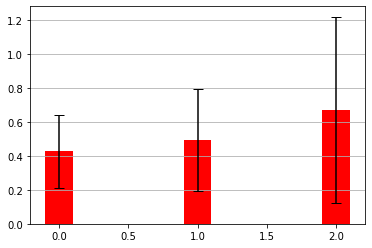

In [0]:
# TEST THE STATISTICAL SIGNIFICANCE AND ERROR BARS

#	user_id	            group_id	exposure
#  0	4vdFVrrYxqb4ofj8RK8xvw	2 	1.442695041
#  1	7BEIyQzlskOV1OAJ0nbweQ	1 	0.9102392266
#  2	GaWT2KIjIxfIBMgGIm7HGw	0 	0.7213475204
# 13	fEYb-rRR1SYSlUnSk0ewpA	1 	0.3692693731
# 14	UWK3mKjnsVOA6sGim6zfgg	2 	0.3606737602
# 15	w8xU5z_-yCXspCfB5bWTJw	0 	0.3529561239
#126	fgRRod48nvfP4WwXiQnNSg	2 	0.2060992916
#127	Wxd9_FATaozi0dhgeh3cPQ	1 	0.2057692596
#128	vQkm_xkJX-OqjZ_PF-pDwA	0 	0.2054428192

test_ranking = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
test_ranking['user_id'] = ['4vdFVrrYxqb4ofj8RK8xvw',
                           '7BEIyQzlskOV1OAJ0nbweQ',
                           'GaWT2KIjIxfIBMgGIm7HGw',
                           'fEYb-rRR1SYSlUnSk0ewpA',
                           'UWK3mKjnsVOA6sGim6zfgg',
                           'w8xU5z_-yCXspCfB5bWTJw',
                           'fgRRod48nvfP4WwXiQnNSg',
                           'Wxd9_FATaozi0dhgeh3cPQ',
                           'vQkm_xkJX-OqjZ_PF-pDwA',
                          ]
test_ranking['group_id'] = [2,1,0,1,2,0,2,1,0]
test_ranking['exposure'] = [1.442695041,0.9102392266,	0.7213475204,
                            0.3692693731,0.3606737602,0.3529561239,
                            0.2060992916,0.2057692596,0.2054428192]

group0 = test_ranking[test_ranking['group_id'] == 0]['exposure']
group1 = test_ranking[test_ranking['group_id'] == 1]['exposure']
group2 = test_ranking[test_ranking['group_id'] == 2]['exposure']
result = stats.ttest_ind(group1, group2)
percent1 = 100*(len(group1.index)/len(test_ranking.index))
percent2 = 100*(len(group2.index)/len(test_ranking.index))
print('+++++++++TEST STATISTICAL SIGNIFICANT+++++++++')
print('GROUP 0:')
print(test_ranking[test_ranking['group_id'] == 0])
print('GROUP 1:')
print(test_ranking[test_ranking['group_id'] == 1])
print('GROUP 2:')
print(test_ranking[test_ranking['group_id'] == 2])
print('STATISTICAL SIGNIFICANCE:')
print(result)

test_exposure = pd.DataFrame(columns=['group_id', 'exposure'])
test_exposure['group_id'] = [0,1,2]
test_exposure['exposure'] = [st.mean(group0), st.mean(group1), st.mean(group2)]

print(test_exposure)

errors = [np.std(group0), np.std(group1), np.std(group2)]
print(errors)

x1 = [el['group_id'] for i, el in test_exposure[['group_id']].iterrows()]
y1 = [el['exposure'] for i, el in test_exposure[['exposure']].iterrows()]
width = 0.20
plt.bar(x1,y1,width=width,align='center', color='red', label='yelp', yerr=errors, ecolor='black', capsize=5)
axes = plt.gca()
axes.yaxis.grid()
plt.show()

In [0]:
def print_statistics_of_demographics(id):
  df = pd.read_csv('demographics_' + id + '.csv')
  all_users = len(df.index)
  print(all_users)

  print('-------------' + id + '--------------')

  u_0_20 = len(df[(df['age']>=0) & (df['age']<=20)])
  print('Utenti in fascia età 0-20: %d (%.2f%%)' % (u_0_20, (u_0_20/all_users)*100))

  u_20_40 = len(df[(df['age']>20) & (df['age']<=40)])
  print('Utenti in fascia età 20-40: %d (%.2f%%)' % (u_20_40, (u_20_40/all_users)*100))

  u_40_60 = len(df[(df['age']>40) & (df['age']<=60)])
  print('Utenti in fascia età 40-60: %d (%.2f%%)' % (u_40_60, (u_40_60/all_users)*100))

  u_60_90 = len(df[(df['age']>60) & (df['age']<=90)])
  print('Utenti in fascia età 60-90: %d (%.2f%%)' % (u_60_90, (u_60_90/all_users)*100))

  u_over_90 = len(df[(df['age']>90)])
  print('Utenti in fascia età >90: %d (%.2f%%)' % (u_over_90, (u_over_90/all_users)*100))

  #temp = df[(df['age']>=0) & (df['age']<=20)][['user_id', 'age']]
  #temp = drop_unnamed(temp)
  #print(temp)

  print('--------------------')

  u_fem = len(df[df['gender']=='feminine'])
  print('Utenti femmine: %d (%.2f%%)' % (u_fem, (u_fem/all_users)*100))

  u_mas = len(df[df['gender']=='masculine'])
  print('Utenti maschi: %d (%.2f%%)' % (u_mas, (u_mas/all_users)*100))

  print('--------------------')

  u_white = len(df[df['ethnicity']=='white'].reset_index(drop=True))
  print('Utenti bianchi: %d (%.2f%%)' % (u_white, (u_white/all_users)*100))
  bianchi = df[df['ethnicity']=='white'].reset_index(drop=True)
  b_under_39 = len(bianchi[(bianchi['age']<39)])
  print('Bianchi in fascia età <39: %d (%.2f%%)' % (b_under_39, (b_under_39/all_users)*100))
  b_over_39 = len(bianchi[(bianchi['age']>=39)])
  print('Bianchi in fascia età >39: %d (%.2f%%)' % (b_over_39, (b_over_39/all_users)*100))
  b_fem = len(bianchi[bianchi['gender']=='feminine'])
  print('Bianchi femmine: %d (%.2f%%)' % (b_fem, (b_fem/all_users)*100))
  b_mas = len(bianchi[bianchi['gender']=='masculine'])
  print('Bianchi maschi: %d (%.2f%%)' % (b_mas, (b_mas/all_users)*100))


  u_black = len(df[df['ethnicity']=='black or african american'])
  print('Utenti neri: %d (%.2f%%)' % (u_black, (u_black/all_users)*100))
  neri = df[df['ethnicity']=='black or african american']
  n_under_39 = len(neri[(neri['age']<39)])
  print('Neri in fascia età <39: %d (%.2f%%)' % (n_under_39, (n_under_39/all_users)*100))
  n_over_39 = len(neri[(neri['age']>=39)])
  print('Neri in fascia età >39: %d (%.2f%%)' % (n_over_39, (n_over_39/all_users)*100))
  n_fem = len(neri[neri['gender']=='feminine'])
  print('Neri femmine: %d (%.2f%%)' % (n_fem, (n_fem/all_users)*100))
  n_mas = len(neri[neri['gender']=='masculine'])
  print('Neri maschi: %d (%.2f%%)' % (n_mas, (n_mas/all_users)*100))

  u_altro = len(df[(df['ethnicity']=='hispanic, latino, or spanish origin') | (df['ethnicity']=='asian') | (df['ethnicity']=='middle eastern or north african') | (df['ethnicity']=='native hawaiian or pacific islander')])
  print('Utenti altre etnie: %d (%.2f%%)' % (u_altro, (u_altro/all_users)*100))
  altri = df[(df['ethnicity']=='hispanic, latino, or spanish origin') | (df['ethnicity']=='asian') | (df['ethnicity']=='middle eastern or north african') | (df['ethnicity']=='native hawaiian or pacific islander')]
  a_under_39 = len(altri[(altri['age']<39)])
  print('Altri in fascia età <39: %d (%.2f%%)' % (a_under_39, (a_under_39/all_users)*100))
  a_over_39 = len(altri[(altri['age']>=39)])
  print('Altri in fascia età >39: %d (%.2f%%)' % (a_over_39, (a_over_39/all_users)*100))
  a_fem = len(altri[altri['gender']=='feminine'])
  print('Altri femmine: %d (%.2f%%)' % (a_fem, (a_fem/all_users)*100))
  a_mas = len(altri[altri['gender']=='masculine'])
  print('Altri maschi: %d (%.2f%%)' % (a_mas, (a_mas/all_users)*100))

  '''u_latino = len(df[df['ethnicity']=='hispanic, latino, or spanish origin'])
  print('Utenti latini: %d (%.2f%%)' % (u_latino, (u_latino/all_users)*100))

  u_asian = len(df[df['ethnicity']=='asian'])
  print('Utenti asiatici: %d (%.2f%%)' % (u_asian, (u_asian/all_users)*100))

  u_arabs = len(df[df['ethnicity']=='middle eastern or north african'])
  print('Utenti arabi: %d (%.2f%%)' % (u_arabs, (u_arabs/all_users)*100))

  u_hawa = len(df[df['ethnicity']=='native hawaiian or pacific islander'])
  print('Utenti hawaiiani: %d (%.2f%%)' % (u_hawa, (u_hawa/all_users)*100))'''



  print('---------ALTRE MISURE-----------')

  u_0_35 = len(df[(df['age']>=0) & (df['age']<35)])
  print('Utenti in fascia età 0-35: %d (%.2f%%)' % (u_0_35, (u_0_35/all_users)*100))
  
  u_35_40 = len(df[(df['age']>=35) & (df['age']<=40)])
  print('Utenti in fascia età 35-40: %d (%.2f%%)' % (u_35_40, (u_35_40/all_users)*100))

  u_over_40 = len(df[(df['age']>40)])
  print('Utenti in fascia età >40: %d (%.2f%%)' % (u_over_40, (u_over_40/all_users)*100))

  print('---------ALTRE MISURE 2-----------')

  u_under_39 = len(df[(df['age']<39)])
  print('Utenti in fascia età <39: %d (%.2f%%)' % (u_under_39, (u_under_39/all_users)*100))
  
  u_over_39 = len(df[(df['age']>=39)])
  print('Utenti in fascia età >39: %d (%.2f%%)' % (u_over_39, (u_over_39/all_users)*100))


id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
for id in id_list:
  print_statistics_of_demographics(id)

1209
-------------WbJ1LRQdOuYYlRLyTkuuxw--------------
Utenti in fascia età 0-20: 25 (2.07%)
Utenti in fascia età 20-40: 865 (71.55%)
Utenti in fascia età 40-60: 293 (24.23%)
Utenti in fascia età 60-90: 24 (1.99%)
Utenti in fascia età >90: 2 (0.17%)
--------------------
Utenti femmine: 775 (64.10%)
Utenti maschi: 434 (35.90%)
--------------------
Utenti bianchi: 693 (57.32%)
Bianchi in fascia età <39: 222 (18.36%)
Bianchi in fascia età >39: 471 (38.96%)
Bianchi femmine: 422 (34.90%)
Bianchi maschi: 271 (22.42%)
Utenti neri: 245 (20.26%)
Neri in fascia età <39: 111 (9.18%)
Neri in fascia età >39: 134 (11.08%)
Neri femmine: 178 (14.72%)
Neri maschi: 67 (5.54%)
Utenti altre etnie: 270 (22.33%)
Altri in fascia età <39: 127 (10.50%)
Altri in fascia età >39: 143 (11.83%)
Altri femmine: 174 (14.39%)
Altri maschi: 96 (7.94%)
---------ALTRE MISURE-----------
Utenti in fascia età 0-35: 306 (25.31%)
Utenti in fascia età 35-40: 584 (48.30%)
Utenti in fascia età >40: 319 (26.39%)
---------ALTRE MIS

In [0]:
# TO UPDATE CENTROIDS
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg'] 
method = 'kmeans'
for id in id_list:
  pd.options.display.float_format = '{:.3f}'.format
  centroids = pd.read_csv('centroids_' + method + '_' + id + '.csv')
  values = [float(x) for x in centroids.columns.values]
  centroids.loc[-1] = values # adding a row
  centroids.index = centroids.index + 1  # shifting index
  centroids.sort_index(inplace=True)
  centroids.columns = ['loc1', 'loc2', 'loc3']  
  centroids.to_csv('centroids_' + method + '_' + id + '.csv', float_format='%.3f')

In [0]:
# TO UPDATE EXPOSURE
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA']
#          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg'] #RICALCOLARE DA CAPO
# id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
for id in id_list:
  df_rel_ranking = pd.read_csv('dataset_rel_ranking_'+id+'.csv')
  df_date_ranking = pd.read_csv('dataset_date_ranking_'+id+'.csv')
  df_rand_ranking = pd.read_csv('dataset_rand_ranking_'+id+'.csv')

  method = 'kmeans'
  N_of_groups = 5
  df_groups = pd.read_csv('groups_' + method + '_'+id+'.csv')
  percents = compute_groups_percents(df_groups, N_of_groups)

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking, reviews, percents)

[21.27659574468085, 20.10981468771448, 18.874399450926564, 19.766643788606725, 19.97254632807138]
[0.15198681815318926, 0.15441688991439814, 0.15644457679065246, 0.1655399171123573, 0.2021502908541474]


NameError: ignored

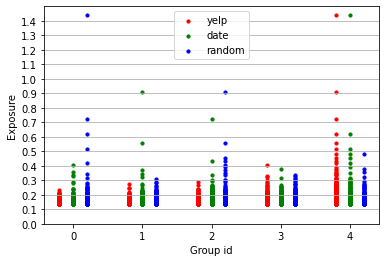

In [0]:
# TO UPDATE PLOTS
id = 'WbJ1LRQdOuYYlRLyTkuuxw'
method = 'custom'
list_of_attributes = ['ethnicity']
exp = 'dispimp'
alluser = False
yelp_exposures = pd.read_csv('exp_' + exp + '_' + method + '_yelp_' + id + '.csv')
date_exposures = pd.read_csv('exp_' + exp + '_' + method + '_date_' + id + '.csv')
random_exposures = pd.read_csv('exp_' + exp + '_' + method + '_random_' + id + '.csv')

yelp_user_exposures = pd.read_csv('user_exp_' + exp + '_' + method + '_yelp_' + id + '.csv')
date_user_exposures = pd.read_csv('user_exp_' + exp + '_' + method + '_date_' + id + '.csv')
rand_user_exposures = pd.read_csv('user_exp_' + exp + '_' + method + '_random_' + id + '.csv')


if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])

df_groups = pd.read_csv('groups_' + method + '_' + id + '.csv')
N_of_groups = 5
percents = compute_groups_percents(df_groups, N_of_groups)

get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_' + exp + '_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error])
get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                  'scatter_' + exp + '_' + method + '_' + business_id, list_of_attributes,
                  method, business_id, alluser)

In [0]:
#ALTERNATIVE METHOD TO SHUFFLE THE RANKING FOR RANDOM
#see https://gist.github.com/cadrev/6b91985a1660f26c2742
business_id = 'WbJ1LRQdOuYYlRLyTkuuxw'
df_rel_ranking = pd.read_csv('rel_ranking_' + business_id + '.csv')
df_date_ranking = df_rel_ranking.sort_values(by=['Date']).reset_index(drop=True)
df_date_ranking['Position'] = df_date_ranking.index + 1
df_rand_ranking = df_rel_ranking

#random.shuffle(df_rand_ranking) DOESN'T WORK KEY ERROR
df_rand_ranking = df_rand_ranking.reindex(np.random.permutation(df_rand_ranking.index))

df_rand_ranking = df_rand_ranking.reset_index(drop=True)

# drop all the unnamed columns
df_rel_ranking = drop_unnamed(df_rel_ranking)
df_rand_ranking = drop_unnamed(df_rand_ranking)
df_date_ranking = drop_unnamed(df_date_ranking)

df_rand_ranking['Position'] = df_rand_ranking.index + 1

print(df_rand_ranking)

df_rel_ranking.to_csv("rel_ranking_" + business_id + ".csv")
df_date_ranking.to_csv("date_ranking_" + business_id + ".csv")
df_rand_ranking.to_csv("rand_ranking_" + business_id + ".csv")

In [0]:
# FILTER RESTAURANTS
is_restaurant = business['categories'].str.contains('Restaurants', regex=False, na=False)
restaurants = business[is_restaurant]

# Filter closed restaurants
restaurants = restaurants[restaurants['is_open'] == 1]

# Order restaurants by review_count
restaurants = restaurants.sort_values('review_count')

restaurants.to_csv('restaurants_input.csv')
# NOW CHOOSE THE RESTAURANTS AND SAVE THEIR IDS INTO TXT FILE

In [0]:
def create_objective_groups_by_size(df_users, attribute, range):
    # order df_users by review_count
    df_users = df_users.sort_values(attribute).reset_index(drop=True)
    group_list = [[]]
    i = 0
    group_index = 0
    prec = -1
    for index, user in df_users.iterrows():
        if i == range:
            i = 0
            group_list.append([])
            group_index = group_index + 1
        temp = user[attribute]
        if temp != prec:
            prec = temp
            i = i + 1
        group_list[group_index].append(user)
    print("Number of groups created: " + str(group_index+1))
    return group_list


In [0]:
### UNIQUE VALUE OF state, city AND categories OF BUSINESS
# To filter only RESTAURANTS
# is_restaurant = business['categories'].str.contains('Restaurants', regex=False, na=False)
# restaurants = business[is_restaurant]

print('UNIQUE VALUE OF \'state\' ATTRIBUTE IN RESTAURANTS = ', business['state'].nunique())
print('UNIQUE VALUE OF \'city\' ATTRIBUTE IN RESTAURANTS = ', business['city'].nunique())
df_cat = business[['categories']]
distinct_categories_list = []
for index, row in df_cat.iterrows():
  if row['categories'] != None:
    lst = [item.strip() for item in row['categories'].split(',')]
    distinct_categories_list = list(set(distinct_categories_list + lst))
print('UNIQUE VALUE OF \'categories\' ATTRIBUTE distinct values ', len(distinct_categories_list))

UNIQUE VALUE OF 'state' ATTRIBUTE IN RESTAURANTS =  36
UNIQUE VALUE OF 'city' ATTRIBUTE IN RESTAURANTS =  1204
UNIQUE VALUE OF 'categories' ATTRIBUTE distinct values  1300


In [0]:
# PRINT THE state OF EACH user FOR HIS RESTAURANT reviews
def statistics(users, reviews, business):
  res = pd.DataFrame()
  cont = 0
  prec_user_id = '0'

  for i, user in users.iterrows():
    if cont == 1000:
      break
    user_id = user['user_id']  # 4, 9, 16, 21!, 22!, 23, 24
    # Get all reviews of one user
    # 'https://www.yelp.com/user_details_reviews_self?userid=NQffx45eJaeqhFcMadKUQA&rec_pagestart=90'??? no
    user_reviews = reviews[reviews['user_id'] == user_id]
    # Get all restaurants
    business_ids = user_reviews[['business_id']]
    result = business_ids.merge(business)
    is_restaurant = result['categories'].str.contains('Restaurants', regex=False, na=False)
    user_restaurant_reviews = result[is_restaurant]
    user_restaurant_reviews['user_id'] = user_id
    #user_restaurant_reviews.to_csv('user_restaurant_reviews' + str(cont) + '.csv')
    res = res.append(user_restaurant_reviews.groupby(['user_id', 'state'])['user_id'].count().reset_index(name="review_count"))
    if (user_id != prec_user_id) and not user_restaurant_reviews.empty:
      cont = cont + 1
    # print(res)
    prec_user_id = user_id

  res.to_csv('result.csv')


In [0]:
def create_df_users(ranking):
  df_ranking = pd.DataFrame(ranking, columns=['position', 'user_id', 'review_count', 'date']).sort_values('position')
  return df_ranking

In [0]:
# TODO: get review_count from web page
def get_ranking(url):

  i=1
  reviews_text = []
  reviews_date = []
  reviews_userid = []
  x=0

  while 1:
    if x == 0:
      page_content = requests.get(url)
    else:
        page_content = requests.get(url + '?start=' + str(x))
    x = x + 20
    
    tree = html.fromstring(page_content.content)
    recommended_reviews_text = "Recommended Reviews"
    reviews_list = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/*' % recommended_reviews_text)
    if not reviews_list:
      break
    else:
      # Index for ranking
      j=1
      for review in reviews_list:
          reviews_text.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[p]/p/span' % (recommended_reviews_text, j))[0].text))
          reviews_date.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[1]/div/div[2]/span' % (recommended_reviews_text, j))[0].text))
          user_link = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div/div/div/div/div/div/a/@href' % (recommended_reviews_text, j))[0]
          reviews_userid.append((i,user_link[user_link.find('=')+1:]))
          i = i + 1
          j = j + 1


  print(reviews_text)
  print("N. of reviews = " + str(len(reviews_text)))
  print(reviews_date)
  print("N. of reviews = " + str(len(reviews_date)))
  print(reviews_userid)
  print("N. of reviews = " + str(len(reviews_userid)))
  return reviews_userid


In [0]:
def find_users_in_dataset(users):
    data = []
    with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            data.append(json_data)
    df = pd.DataFrame(data)
    df_ranking = pd.DataFrame(users, columns=['Position', 'user_id'])
    df_merged = df_ranking.merge(df, on='user_id')
    # temp = df[df['user_id'].isin(users)]
    return df_merged


def exists_in_dataset(userid):
  found = False
  with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            if json_data['user_id'] == userid:
              found = True
  if found:
    print("Trovato")
  else:
    print("Non trovato")
  return found


def find_users_in_chopped_dataset(users):
    found = False
    data = []
    i = 1
    j = 100000
    df_users = pd.DataFrame()
    while not found:
        path = "user" + str(i) + "-" + str(j) + ".json"
        try:
            with open(path, 'r') as file:
                for line in file:
                    json_data = json.loads(line)
                    data.append(json_data)
            df = pd.DataFrame(data)
        except FileNotFoundError:
            print("Cannot find all users into the dataset")
            return 0
        else:
            temp = df[df['user_id'].isin(users)]  # df of users of the ranking
            df_users = df_users.append(temp)
            if df_users.shape[0] == len(users):
                found = True
            else:
                i = i + 100000
                j = j + 100000
    return df_users
